# Processing of particle tracks 
### <font color='gray'>coded to work with experiments and simulation</font>

## _Import of python libraries used within the code_

### <font color ='gray'> load both code cells  </font>  

In [1]:
###### HI HELLO
import numpy as np # fast array library
import pandas as pd # data frames library
from pandas_ods_reader import read_ods #read ods tables

import matplotlib 
import matplotlib.pyplot as plt # plot library
import matplotlib.gridspec as gridspec
 
import subprocess # these 2 lines below load OS functionality
import sys
import json
import warnings

from IPython.display import display, HTML # screen on display in HTML library 

import sympy as sp # symbolic calculation library functions
from sympy import var # symbolic calculation library variables

import mpmath as mp # double (or higher) floating point precision library (not used)

import scipy.constants as ct # import mathematical constants
import scipy.special as spec
from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions
import scipy.optimize as optimize # optimazation library (not used)
from scipy import signal # noise filtering functions
from scipy import stats # statistics, for binning and fields calculation
from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions


import ipywidgets as widgets # import 

from collections import Counter # (not used)
import time # timing functions (for computation time)

global iscaled 
iscaled = 0

global LX, LY
LX = 1000 -250
LY = 650-50

# system size for a given (npart, rho) configuration
def L(npart, rho):
    l = np.sqrt(npart*2*np.sqrt(3.)/rho)
    return l

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()
    
#from __future__ import print_function

# Text format for figures configuration (lines below)
from matplotlib import rc
plt.rcParams['font.family'] = 'Arial'
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

# special plotting functions
from matplotlib.collections import PolyCollection
import matplotlib.colors as mcolors

def set_up_graf(idf, LX, LY):
    global ax, fig_system, ss

    fig_system = plt.figure(idf, figsize=(6.5,6.5*LY/LX))
    ss=(72./fig_system.dpi)**2 # particle size
    ax = fig_system.add_subplot(1, 1, 1)
    ax.set_ylim([0,LY])
    ax.set_xlim([0,LX])
    ax.set_xlabel(r'$x/\sigma$',fontsize = 14)
    ax.set_ylabel(r'$y/\sigma$', fontsize = 14)



In [2]:
#experiments = pd.read_excel('/data/Datos/blades/tabla_04_2021.xlsx', engine='openpyxl', sheet_name=0)
experiments = read_ods('/home/fvega/Datos/blades/tabla_experimentos.ods', sheet=0)
experiments = experiments[['ID', 'N', 'fps','Tt', 'w']][:115]

In [3]:
experiments.tail()

,ID,N,fps,Tt,w
110,8216db06b6056089227eb64e4684a18a,65.0,250.0,1.309329,0.073209
111,4b5ad88c38299aae67bf0ad78bba6ce4,70.0,250.0,0.823637,-0.160636
112,fe31fde8967132010ff1a697ccc745c4,70.0,900.0,0.823637,-0.160636
113,d634e107afaa4f8fcb0cf4e945bc77ec,70.0,250.0,0.824690,-0.118647
114,cf2f31545a4ff55ebcede0e40706fdec,70.0,900.0,0.824690,-0.118647


In [4]:
%matplotlib --list

Available matplotlib backends: ['agg', 'auto', 'cairo', 'gtk3', 'gtk3agg', 'gtk3cairo', 'gtk4', 'gtk4agg', 'gtk4cairo', 'inline', 'ipympl', 'macosx', 'nbagg', 'notebook', 'osx', 'pdf', 'pgf', 'ps', 'qt', 'qt5', 'qt5agg', 'qt5cairo', 'qt6', 'qtagg', 'qtcairo', 'svg', 'template', 'tk', 'tkagg', 'tkcairo', 'webagg', 'widget', 'wx', 'wx', 'wxagg', 'wxcairo']


In [5]:
# matplotlib widgets interface
%matplotlib ipympl 


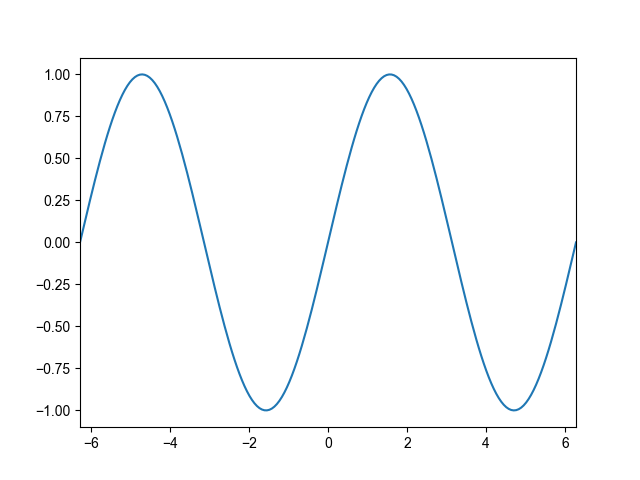

In [6]:
plt.figure()
plt.xlim(-2*np.pi, 2*np.pi)
plt.plot(np.linspace(-2*np.pi,2*np.pi,200), np.sin(np.linspace(-2*np.pi,2*np.pi,200)))

## _Read tracking data_ 

We explain the action of each of these functions below:

__get_info(hash_prefix) :__ Reads and prints info file with  _hash prefix_ hash code. See output table in <font color='red' >RUN CELL 0</font> below to grasp the info structure

__simple_pickle_read(hash_prefix) :__
This 'simple_pickle_read' takes a pkl.xz file _hash prefix_ hash code, and which contains xy positions and tracks (no velocities) and stores in 'tabla' pandas data frame.
   
  * input: hash_prefix
  * output: global variable _Ntracks_ (number of tracks) 

In [7]:
def pdisplay(info):
    display(HTML(info.to_html()))

# This function reads pickle binary file (.pkl) with trajectories
def get_info(series_directory, hash_prefix, silent):
    global info
    nombre = '/home/fvega/Datos/blades/' + series_directory + '/info/'  + hash_prefix + '.txt'
    with open(nombre) as f:
        jsonstr = json.load(f)
    info = pd.json_normalize(jsonstr)
    if silent==False:
        pdisplay(info.T)
    return info
    
def simple_pickle_read(series_directory, hash_prefix):
    global Nframes, Ntracks
    # Read table in pickle format
    nombre = '/home/fvega/Datos/blades/' + series_directory + '/ref_angle/' +  hash_prefix \
       + '.pkl.xz'
    tabla = pd.read_pickle(nombre, compression='infer')
    tabla = tabla.reset_index(drop=True) # por si los indices salen desordenados
    Nframes = np.max(tabla.frame)
    Ntracks = np.max(tabla.track)+1
    tabla = tabla.sort_values(by = ['frame', 'track']).reset_index(drop=True)
    return tabla


In [39]:
get_info('packing_fraction_025', 'd0baa24f923acbcef2669ee168622e45', True).T

,0
experiment_id,d0baa24f923acbcef2669ee168622e45
original_file,D:/serieAspas/renivelado/movies\serieAspas_N25...
date,2038-01-19 08:06:03
shape,"[1280, 800]"
fps,900
exposure,1109
n_frames,24981
recording_time,27.756667
camera_distance,0.95
pixel_ratio,1075.862069


## _Reduce global table - functions_

__reset_track_indexes(tabla0):__ 
Eliminates 'lonely' tracks (particles tracked for just 1 frame), re-indexes so that no track indexes are empty
* input: _tabla0_ original data frame (of tracks)
* output: RETURNS clean _tabla_ data frame, without empty tracks; AND original _tabla0_ with empty tracks still included
* output structure: _tabla0_, _tabla_

__short_drop:(ishort, tabla):__ 
Eliminates tracks detected for n frames or less, re-indexes so that no track indexes are empty

* Input: _ishort_ (threshold length of tracks: shorter tracks are not kept), _tabla_ (original tracks data frame)

* Output: RETURNS _tabla_\__short_ (frame), that is the input table _tabla_ without tracks shorter than _ishort_


In [8]:
def reset_track_indexes(tabla0, silent):
    global Ntracks, Nframes
    """ This function takes a dataframe in which some trajectory indexes
        are missing (maybe due to having deleted short trajectories) and
        resets indexes so that we can loop over the tracks with 'range' """
    # 'real_number_of_tracks' should be <=  than 'current_last_particle_index'
    tabla = tabla0.copy()
    Ntracks = len(set(tabla.track))
    original_indexes = np.sort(list(set(tabla.track)))
    unsort_indexes = original_indexes
    fixed_indexes = np.arange(0, Ntracks, step=1, dtype=int)
    if  (original_indexes == fixed_indexes).all()==False: # fix only if there are empty tracks
    # With these two lists we create a dictionary and map old values to new ones
        n_empty = np.max(tabla.track) - Ntracks
        replacement_dict = dict(zip(original_indexes, fixed_indexes))
        tabla.track = tabla.track.map(dict(zip(original_indexes, fixed_indexes)))
        if silent == False:
            print('no. of empty track indexes discarded: ', n_empty, '\n')
    else:
        if silent == False:
            print('nothing to fix\n')
    Ntracks = np.max(tabla.track)+1
    Nframes = np.max(tabla.frame)
    return tabla0, tabla

# INPUT
# ishort: number of minimum frames in a track (eliminates tracks under ishort time length)
# tabla: pandas Data Frame to shorten
# OUTPUT
def short_drop(ishort, tabla, silent):
    global shorts_list, Ntracks
    shorts_list =[]
    Ntracks = np.max(tabla.track)+1
    for i in range(Ntracks):
        t1 = track(i,tabla,False)
        if  len(t1) < ishort+1:
            shorts_list.append(i)
            len0 = len(tabla)
            tabla = tabla.drop(t1['index'])
            texto = 'dropped track no. '+str(i)+'; data table length decreased in '+str(len(tabla)-len0)
            if silent ==False:
                printp(texto)
    print('\n')
    tabla_short = tabla.sort_values(by = ['frame', 'track']).reset_index(drop=True)
    Nshorts = np.max(tabla_short.track)+1
    if silent ==False:
        printp('Dropped out ' + str(Ntracks-Nshorts)+' short tracks out of ' + str(Ntracks))
    # the line above is necessary so that eliminates index voids and shuffling after short drop
        print('\n')
    return tabla_short


## _Get tracks and states from global table - functions_

__track(t_id, tabla, dropit) :__  builds track for one particle from the appropriate chunk of the source table, with only the lines for particle _t_\__id_ 

* Input: _t_\__id_ indice de track, _tabla_ source frame fuente (contains tracks), _dropit_ boolean; if =True then erases old index column (tracks do not always begin in frame 0); most of the time you just want _dropit_=True

* Output: RETURNS a chunk of source table _tabla_ with only the lines for particle _t_\__id_

__all\___ __tracks(tabla, dropit):__ repeats the process in _track_ function for all existing particles

* Input: _tabla_ (frame) data source, _dropit_ boolean variable set True to erase original table original line number

* Output: RETURNS _track_ array of frames each wiith one particle track; builds _tr_\__lengths_ array of tracks lengths


__state(it, tabla):__ gets one instantaneous state frome source frame _tabla_, at frame _it_

* Input: _it_ frame no. to get the state from; _tabla_ source frame data

* Output: RETURNS st frame chunk from _tabla_ source frame

__all__\___states(tabla):__ Builds all instantaneous states from the movie

* Input: _tabla_ source frame data

* Output: RETURNS array of frame chunks from _tabla_ source frame. each chunk being an instantaneous state

In [9]:
#####  INDIVIDUAL TRACKS ##############
# build a 't_id' indivitual track 
def trackf(t_id, tabla, dropit):
    t1 = tabla.loc[tabla.track == t_id].reset_index(drop=dropit)
    return t1

# build individual tracks from all kept tracks
# OUTPUT
# tr_lengths[i]: length of track no.  'i'. The total no. of tracks is stored in 'Ntracks'
def all_tracks(tabla,dropit):
    # length of track
    global tr_lengths
    tr_lengths = np.empty(Ntracks,dtype=int)
    tracks = [[] for i in range(Ntracks)]
    for i in range(Ntracks):
        tracks[i] = trackf(i,tabla,dropit)
        tr_lengths[i] = int(len(tracks[i]))
    return tracks

#####  INSTANTANEOUS STATES  ##############
# BUILD INSTANTANEOUS STATES OF THE SYSTEM
def state(it, tabla):
    st = tabla.loc[tabla.frame == it].reset_index(drop=True)
    # reset row index 
    #(otherwise keeps chunked index of the original table)
    return st

# build instantaneous states over all frames
def all_states(tabla):
    sts = [[] for i in range(Nframes)]
    for i in range(Nframes):
        sts[i] = state(i,tabla)
    return sts


## Processing of blades angles

The process has the following steps:
 
* Eliminating blades with angles: $\theta_i >2 \pi$
* Storing angle list length
* Interpolating missing angles for those lists with angles length < no. of blades

In [10]:
# save max and/or min angles and re-scale angle unit
circ_unit = 14 # NUMBER OF BLADES IN PARTICLES

# SCALE ANGLES TO blades. builds separately minima ('mint') and maxima colums ('maxt')
def save_rescale_angle(imin, tabla):
    ln = len(tabla)
    maxs = [ [] for i in range(ln) ]
    for i in range(ln):
        maxs[i] = tabla.extremos[i][0] * circ_unit/360
    #maxs = [tabla.extremos[i][0] for i in range(ln)] # keeps angle maxima
    #maxs = np.array([tabla.extremos[i][0] for i in range(ln)]) # keeps angle maxima
    #maxs = circ_unit*(maxs/360)
    tabla['maxt'] = maxs # transforms angle into blade units
    if imin != 0:
        mins = [ [] for i in range(ln) ]
        for i in range(ln):
            mins[i] = tabla.extremos[i][1] * circ_unit/360
        tabla['mint'] = mins
    return tabla

# deletes blades beyond the forteenth blade (the last one in this case) + 1/2 blade
def filter_spurious_angles(imin,tabla):
    for i in range(len(tabla)):
        tabla.at[i,'maxt'] = np.array(list(filter(lambda x: x<(circ_unit+0.5), tabla.maxt[i])))
    if imin != 0:
        for i in range(len(tabla)):
            tabla.at[i,'mint'] = np.array(list(filter(lambda x: x<(circ_unit+0.5), tabla.mint[i])))
    return tabla

def filter_outside_blades(tabla):
    for i in range(len(tabla)):       
        try:
            #np.where(tabla.maxt[i]>14)[0][0]
            lista =  np.where(tabla.maxt[i]>14)[0]
            if len(tabla.maxt[i]) > 15:
                print("DANGER! DANGER! DANGER!\n")
            if len(tabla.maxt[i]) > 14: 
                for k in lista:
                    tabla.at[i,'maxt'] = np.delete(tabla.at[i,'maxt'],k) 
                    # deletes outside blades (+1/2) if list length > 14
            else:
                for k in lista:
                    tabla.at[i,'maxt'][k] = tabla.at[i,'maxt'][k] - 14
                    a = tabla.maxt[i][k]
                    tabla.at[i,'maxt'] = np.delete(tabla.maxt[i], k) 
                    # substract nblades to outside blades if list length < 14
                    tabla.at[i,'maxt'] = np.insert(tabla.maxt[i], 0, a)
                    # place it at the beginning of the list
        except:
            pass
    return tabla


# Deletes one excess element in maxima arrays
# based on  closest to 1 difference (between first and last pair)
def last_del15(tabla,larr):
    if len(np.where(larr==15)[0])>0:
        for i in np.where(larr==15)[0]:
            arr = tabla.maxt[i]
            if (np.abs(arr[1]-arr[0]-1) < np.abs(arr[14]-arr[13] -1)):
                tabla.at[i,'maxt'] = np.delete(arr,-1)
            else:
                tabla.at[i,'maxt'] = np.delete(arr,0)
    return tabla

# Stores in a list the angles lists lengths; of either maxt or mint (not simultaneously)
def angles_list_lengths(arr):
    la = []
    for i in arr:
        la.append(len(i))
    la = np.array(la).astype(int)
    return la


# insert_missing: 
# detects missing blades, linearly interpolates them, only for just one missing angle
def insert_missing(tabla, larr):
# PROCEDIMIENTO PARA INTERPOLAR listas de maximos con menos de 14 maximos
    while len(np.where(larr==13)[0]) > 0:
        interpolated_indexes = np.zeros(len(np.where(larr==13)[0]))
        for i in np.where(larr < 14)[0]:
            diff_arr = tabla.maxt[i][1:] - tabla.maxt[i][:-1]
            imax = np.where(diff_arr == np.max(diff_arr))[0][0] # maximum index
            interpolated_indexes = np.append(interpolated_indexes, imax)
            tabla.at[i,'maxt'] = np.insert(tabla.maxt[i], imax+1, 0.5 * (tabla.maxt[i][imax] + tabla.maxt[i][imax+1]))
        larr = angles_list_lengths(tabla.maxt)
    print('done\n')
    return tabla



## return_next: 
### finds angle location of a reference blade (j0) in next frame jt+1, within track no. itr
### returns the angle difference with respect to that location
__input__ : _itr_ (track no.), _jt_ (reference frame no.), _j0_ (reference blade)

__output__: _in0_ (theta diff. index taken), _diffnext0_ (omega from theta diff taken)

In [11]:
nblades = circ_unit

def return_next(tabla, jt,j0):
    
    list_its = [j0, j0-1, j0+1]
    
    theta0 = tabla.maxt[jt][j0]
    # by default, angle difference is with itself in the next frame
    diff0 = tabla.maxt[jt+1][j0] - theta0 # ldiff0, rdiff0
    
    if (j0==0):
        ldiff = tabla.maxt[jt+1][nblades-1] - theta0 - circ_unit 
        list_its[1] = nblades-1
    else:
        ldiff = tabla.maxt[jt+1][j0-1] - theta0 
        
    if (j0==nblades-1):
        rdiff = tabla.maxt[jt+1][0] - theta0 + circ_unit
        list_its[2] = 0
    else:
        rdiff = tabla.maxt[jt+1][j0+1] - theta0
    
    list_diffs = [diff0, ldiff, rdiff]

    inm = np.where(np.abs(list_diffs) == np.min(np.abs(list_diffs)))[0][0] 
    
    in0 = list_its[inm]
    diffnext0 = list_diffs[inm]

    return in0, diffnext0


def shift_back(tabla,jt,n0):
    arr_copy = np.zeros(nblades)
    for i in range(n0,nblades):
        arr_copy[i-n0] = tabla.maxt[jt][i]
    for i in range(0,n0):
        arr_copy[(nblades-1)-(n0-1)+i] = tabla.maxt[jt][i]
    return arr_copy


## process_ns: 
### processes one experiment, only the translational variables, finding velocities
__input__ : _series_directory_, _hash_prefix_, _silent_ (wheter output messages or not; messages report position stats and process evolution)


In [12]:
def process_ns(series_directory, hash_prefix, silent):
    
    if silent==False:
        print('data reading and basic processing\n')

    info = get_info(series_directory, hash_prefix, silent)
    Ntracks= info.N[0]
    
    datos_ns = simple_pickle_read(series_directory, hash_prefix)
    datos_orig_ns, datos_ns = reset_track_indexes(datos_ns, silent)

    datos_ns = datos_ns[['frame','track','x','y']]


    # image_flip_y
    datos_ns.loc[:,'y'] = info['shape'].values[0][1] - datos_ns.y.values
    
    # change reference point to ROI center (ROI CENTER y coordinate is flipped)
    datos_ns.loc[:,'x'] = datos_ns.loc[:,'x'] - info.ROI_center[0][0]
    datos_ns.loc[:,'y'] = datos_ns.loc[:,'y'] - (info['shape'][0][1] - info.ROI_center[0][1])
    
    # create distance to center column
    datos_ns['r'] = np.sqrt( datos_ns.x**2  + datos_ns.y**2 )
    
    # imprime (formateada) cabecera de tabla de datos
    if silent== False:
        pdisplay(datos_ns.head())  
        print('\n min for positions:\n', np.min(datos_ns[['x','y']]), '\n')
        print('max. for positions:\n', np.max(datos_ns[['x','y']]), '\n')
        print('\n average for x,y positions:\t', np.mean(datos_ns.x), np.mean(datos_ns.y), '\n')
        print('storing all tracks (maxima arrays corrected)')
    # store tracks individually
    tracks = all_tracks(datos_ns, True)
    
    if silent== False:
        print('filtering positions\n')
    # filtering positions via savgol method. here using a window of 15 frames and a 3rd degree polynomial
    for i in range(Ntracks):
        tracks[i].loc[:,'x'] = signal.savgol_filter(tracks[i].x.values, 5, 3)
        tracks[i].loc[:,'y'] = signal.savgol_filter(tracks[i].y.values, 5, 3)
        
    
    Ntracks = info.N[0]
    
    for i in range(Ntracks):
    
        # velocities
        diffsx = tracks[i].x[1:].values - tracks[i].x[:-1].values
        diffsy = tracks[i].y[1:].values - tracks[i].y[:-1].values
        tracks[i] = tracks[i].drop(len(tracks[i])-1)
        tracks[i]['vx'] = diffsx
        tracks[i]['vy'] = diffsy
        
        # accelerations
        adx = tracks[i].vx[1:].values - tracks[i].vx[:-1].values
        ady = tracks[i].vy[1:].values - tracks[i].vy[:-1].values
        tracks[i] = tracks[i].drop(len(tracks[i])-1)
        tracks[i]['ax'] = adx
        tracks[i]['ay'] = ady
        
        tracks[i] = tracks[i][['frame', 'track', 'x', 'y', 'r', 'vx', 'vy', 'ax', 'ay']] # no spin

    if silent == False:
        print('building tracks\n')
    
    ### REBUILD DATA TABLE
    datos_ns = tracks[0].copy() # this is necessary because we derive v's and ws from tracks

    for i in range(1,Ntracks):
        datos_ns = pd.concat([datos_ns, tracks[i]], ignore_index=True )
    ### end rebuild data table
    
    datos_ns = datos_ns[['frame', 'track', 'x', 'y', 'r', 'vx', 'vy', 'ax','ay']]
    
    print('done with tracks: ', hash_prefix , '\n')
    return datos_ns, datos_orig_ns, tracks


In [95]:
datos_ns, datos_orig_ns, tracks = process_ns('packing_fraction_045','656ac3f84a53672294b835362a2c563f', False)

data reading and basic processing



,0
experiment_id,656ac3f84a53672294b835362a2c563f
original_file,D:/serieAspas/renivelado/movies\serieAspas_N45_p22_fps250_est_renivel.cine
date,2038-01-19 05:13:14
shape,"[1280, 800]"
fps,250
exposure,1500
n_frames,24981
recording_time,99.924
camera_distance,0.95
pixel_ratio,1075.862069


nothing to fix



,frame,track,x,y,r
0,1,0,-67.644849,-291.746883,299.486343
1,1,1,-182.336534,43.593375,187.475315
2,1,2,65.706729,73.501721,98.589438
3,1,3,247.064736,86.119658,261.643993
4,1,4,-115.234277,96.556889,150.340186



 min for positions:
 -347.6327018262501 

max. for positions:
 361.65347361389445 


 average for x,y positions:	 18.617161570189516 24.239908377494345 

storing all tracks (maxima arrays corrected)
filtering positions

building tracks

done with tracks:  656ac3f84a53672294b835362a2c563f 



In [98]:
datos_ns[datos_ns.track==1]

,frame,track,x,y,r,vx,vy,ax,ay
24979,1,1,-182.341601,43.587290,187.475315,-0.250629,-0.199329,0.020390,-0.018968
24980,2,1,-182.592231,43.387961,187.690513,-0.230240,-0.218297,0.001233,-0.102906
24981,3,1,-182.822471,43.169665,187.828946,-0.229007,-0.321203,-0.051409,-0.108435
24982,4,1,-183.051477,42.848462,188.023229,-0.280416,-0.429638,-0.040648,0.056031
24983,5,1,-183.331893,42.418824,188.159183,-0.321064,-0.373607,-0.065249,-0.007807
...,...,...,...,...,...,...,...,...,...
49953,24975,1,-231.802324,-213.388511,315.041786,0.148103,0.264290,0.065125,-0.001966
49954,24976,1,-231.654221,-213.124221,314.836759,0.213228,0.262324,0.074275,-0.029514
49955,24977,1,-231.440993,-212.861897,314.391720,0.287502,0.232810,0.037786,-0.158937
49956,24978,1,-231.153491,-212.629087,314.106709,0.325289,0.073873,-0.024733,-0.023947


## process: 
### processes one experiment, both translational AND rotational variables, finding velocities and spins
__input__ : _series_directory_, _hash_prefix_, _silent_ (wheter output messages or not; messages report position stats and process evolution and angle processing info plots)


In [15]:
def process(series_directory, hash_prefix, silent, plot_silent):

    # COMPLETE SET OF READING INSTRUCTIONS
    
    print('data reading and basic processing\n')
    
    info = get_info(series_directory, hash_prefix, silent)
    Ntracks= info.N[0]
    
    datos = simple_pickle_read(series_directory, hash_prefix)
    datos_orig, datos = reset_track_indexes(datos, silent)
    
    datos = datos[['frame','track','x','y','extremos']]
    #datos = datos[['frame','track','x','y']]
    
    # image_flip_y
    datos.loc[:,'y'] = info['shape'].values[0][1] - datos.y.values
    # image_flip_vy
    #datos.loc[:,'vy'] = -datos.vy.values
    
    # change reference point to ROI center
    datos.loc[:,'x'] = datos.loc[:,'x'] - info.ROI_center[0][0]
    datos.loc[:,'y'] = datos.loc[:,'y'] - (info['shape'][0][1] - info.ROI_center[0][1])
    
    # create distance to center column
    datos['r'] = np.sqrt( datos.x**2  + datos.y**2 )
    #datos['r'] = np.sqrt((datos.x- info.ROI_center[0][0]) **2  + (datos.y- info.ROI_center[0][1]) **2 )
    
    if silent == False:
        print('\n min for positions:\n', np.min(datos[['x','y']]), '\n')
        print('max. for positions:\n', np.max(datos[['x','y']]), '\n')
        print('\n average for x,y positions:\t', np.mean(datos.x), np.mean(datos.y), '\n')
    
    save_rescale_angle(0, datos) #builds maxt (and mint) columns
    #pdisplay(datos.head())
    del datos['extremos'] # remove original clumpsy angles list structure
    #pdisplay(datos.head())
        
    ##### delete too short lists; interpolating (linearly) complete new ones instead ####
    la = angles_list_lengths(datos['maxt'].to_numpy())
    lashort =  np.where(la<10)[0]
    
    if silent == False:
        print('short lists of extrema are ', "{0:.4f}%".format(len(lashort)/Nframes))
    
    for i in lashort:
        datos.at[i,'maxt'] = 0.5*(datos.at[i-1,'maxt'][:nblades]+datos.at[i+1,'maxt'][:nblades])
    
    # imprime (formateada) cabecera de tabla de datos
    if silent == False:
        pdisplay(datos.head())
        print('filtering spurious angles \n')
        
    datos = filter_spurious_angles(0,datos)
    
    la = angles_list_lengths(datos['maxt'].to_numpy())
    
    if plot_silent == False:
        plt.figure(figsize=(8,8/ct.golden))
        plt.hist(la,rwidth=0.96, bins=[11,12,13,14,15,16,17],color='r',density=True,align='left')
    
    if silent == False:
        print('filtering close outside blades\n')
    datos = filter_outside_blades(datos)
    
    la = angles_list_lengths(datos.maxt)
    
    if plot_silent == False:
        plt.figure(figsize=(8,8/ct.golden))
        plt.hist(la,rwidth=0.96, bins=[5,6,7,8,9,10,11,12,13,14,15,16,17],color='r',density=True,align='left');
    
    if silent == False:
        print('delete last in angle arrays with one excess blades (last one is < (nblades+1/2 blade) )\n')
    datos = last_del15(datos,la)
    
    la = angles_list_lengths(datos['maxt'].to_numpy())
    
    if plot_silent == False:
        plt.figure(figsize=(8,8/ct.golden))
        plt.hist(la,rwidth=0.96, bins=[5,6,7,8,9,10,11,12,13,14,15,16,17],color='r',density=True,align='left');
    
    if silent == False:
        print('interpolating missing maxima\n')
    datos = insert_missing(datos, la)
    
    la = angles_list_lengths(datos['maxt'].to_numpy())
    
    if silent == False:
        if np.any(la!=14) == False: 
            print(np.where(la!=14)[0])
            print('14-blades max angle lists ready')
        else:
            print(np.where(la!=14)[0])
            print("STOP CODE: angle processing failed")
    
    if plot_silent == False:
        plt.figure(figsize=(8,8/ct.golden))
        plt.hist(la,rwidth=0.96, bins=[5,6,7,8,9,10,11,12,13,14,15,16,17],color='r',density=True,align='left');
    
    
    if silent == False:
        print('storing all tracks (maxima arrays corrected)')
    # store tracks individually
    tracks = all_tracks(datos, True)
    
    Ntracks = info.N[0]
    
    if silent == False:
        print('filtering positions\n')
    
    # filtering positions via savgol method. here using a window of 15 frames and a 3rd degree polynomial
    for i in range(Ntracks):
        tracks[i].loc[:,'x'] = signal.savgol_filter(tracks[i].x.values, 9, 3)
        tracks[i].loc[:,'y'] = signal.savgol_filter(tracks[i].y.values, 9, 3)
    
    
    Ntracks = info.N[0]
    
    if silent == False:
        print('filtering angles and spins & processing angular and translational velocities...\n')
    #reposition angles so that each position in the angle array is each moving blade
    # obtain spins (omega) from there
    theta = np.zeros((Ntracks,Nframes), dtype=float)
    omega = np.zeros((Ntracks,Nframes), dtype=float)
    
    for j in range(Ntracks):
        ln = len(tracks[j])
        theta[j][0] = np.mean(tracks[j].maxt[0]- np.arange(circ_unit))
        ianext, omega[j][0] = return_next(tracks[j], 0, 0)
        for i in range(1,ln-1):
            if (i%500)==0:  printp('track no. ' + str(j+1)+ ' of ' + str (Ntracks) + ', frame ' + str(i)+ ' of ' + str(Nframes-2))
            theta[j][i] = np.mean(tracks[j].maxt[i]- np.arange(-ianext ,circ_unit -ianext))
            ianext, omega[j][i] = return_next(tracks[j], i , ianext)
        theta[j][ln-1] = np.mean(tracks[j].maxt[ln-1]- np.arange(-ianext ,circ_unit -ianext))   
        
    tracks[0].head()
    
    if plot_silent == False:
        plt.figure()
        plt.hist(omega[0],bins=200);
    
    for i in range(Ntracks):
        # store angular part in tracks # comment for 250 fps tracks
        tracks[i]['theta'] = theta[i][:len(tracks[i])]
        tracks[i]['w'] = omega[i][:len(tracks[i])]
        tracks[i].loc[:,'theta'] = signal.savgol_filter(tracks[i].theta.values, 3, 2)
        tracks[i].loc[:,'w'] = signal.savgol_filter(tracks[i].w.values, 3, 2)
        # line above needs to be modified to:
        # tracks[i].loc[:,'w'] = np.diff(tracks[i].theta.values)
        #tracks[i] = tracks[i].drop('maxt', axis=1)
    
        ## velocities
        ln = len(tracks[i])
        tracks[i] = tracks[i].drop([ln-1-i for i in range(ln%3)]) # table has to be multiple of step (here, 3)
        ln = len(tracks[i])
        ddx = np.empty(ln-3) # drop step (3) last elements, which will not have velocity
        ddy = np.empty(ln-3) # drop step (3) last elements, which will not have velocity
        for j in range(3): 
            ddx[j::3] = tracks[i].x[3+j::3].values - tracks[i].x[j:-3:3].values
            ddy[j::3] = tracks[i].y[3+j::3].values - tracks[i].y[j:-3:3].values
        tracks[i] = tracks[i].drop([ln-1-k for k in range(ln - len(ddx))]) # tracks has to have also dd's length
        tracks[i].loc[:,'vx'] = ddx
        tracks[i].loc[:,'vy'] = ddy
        
        ## accelerations
        #adx = tracks[i].vx[1:].values - tracks[i].vx[:-1].values
        #ady = tracks[i].vy[1:].values - tracks[i].vy[:-1].values
        #tracks[i] = tracks[i].drop(len(tracks[i])-1) # delete last (has no acceleration)
        #tracks[i]['ax'] = adx
        #tracks[i]['ay'] = ady
        
        #tracks[i] = tracks[i][['frame', 'track', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'theta','w']]
        tracks[i] = tracks[i][['frame', 'track', 'x', 'y', 'r', 'vx', 'vy', 'theta','w']]
        #tracks[i] = tracks[i][['frame', 'track', 'x', 'y', 'r', 'vx', 'vy', 'w']]
    
        
    # REBUILD DATA TABLE, ORDERED BY TRACK AND WITH theta (only) ANGLE
    del datos['maxt'] # remove original clumpsy angles list structure
   
    datos = tracks[0].copy() # this is necessary because we derive v's and ws from tracks

    print('Ntracks: ', Ntracks)
    for i in range(1,Ntracks):
        datos = pd.concat([datos, tracks[i]], ignore_index=True )
    #datos = datos.reset_index(drop=True)
    
  # if silent == False:
  #     print('\n last angle fix\n')
  #     
  # if np.any(datos.theta.values > circ_unit): # fix angles > 360 degrees if there is any
  #     datos.loc[np.where(datos.theta.values > circ_unit)[0], 'theta'] =\
  #     datos.theta[np.where(datos.theta.values > circ_unit)[0]][:] - circ_unit
  # if np.any(datos.theta.values < 0):  # fix negative angles if there is any
  #     datos.loc[ np.where(datos.theta.values < 0)[0],'theta'] =\
  #     circ_unit + datos.theta[np.where(datos.theta.values < 0)[0]] 
    
    ##### LAST COORDINATE TRANSFORMATIONS ###########
    
    # redefine angle after flip to rad
    #datos.loc[:,'theta'] = nblades + 1 - datos.loc[:,'theta']
    datos.loc[:,'w'] = -datos.loc[:,'w']
    #del datos['maxt'] # remove original clumpsy angles list structure
    
    if silent == False:
        pdisplay(datos.head())
    
    if np.any(datos.theta.values<0)==False and np.any(datos.theta.values>14)==False:
        print('\n theta angle list, is between 0 and', circ_unit ,  'AND TOTALLY READY\n')    
    
    print('done with tracks: ', hash_prefix , '\n')
    return datos, datos_orig, tracks
#

In [34]:
datos, datos_orig, tracks = process('packing_fraction_025','d0baa24f923acbcef2669ee168622e45', False, True)

data reading and basic processing



,0
experiment_id,d0baa24f923acbcef2669ee168622e45
original_file,D:/serieAspas/renivelado/movies\serieAspas_N25_p25_fps900_est_renivel.cine
date,2038-01-19 08:06:03
shape,"[1280, 800]"
fps,900
exposure,1109
n_frames,24981
recording_time,27.756667
camera_distance,0.95
pixel_ratio,1075.862069


nothing to fix


 min for positions:
 -343.22173702086366 

max. for positions:
 394.66666666666663 


 average for x,y positions:	 27.17458758792745 34.13240866832756 

short lists of extrema are  0.0029%


,frame,track,x,y,r,maxt
0,1,0,43.283241,-286.609681,289.859532,"[0.7713238344221941, 1.8074737984883913, 2.7942541944461174, 3.6740941261122138, 4.648256420588761, 5.628870050052378, 6.542609678397538, 7.550310209982947, 8.520744000363546, 9.5203362470278, 10.602240292087417, 11.634772540578274, 12.711084219169123, 13.70678709605044, 14.771323834422194, 15.80747379848839]"
1,1,1,50.347634,351.145406,354.736494,"[0.5768690458969543, 1.5059595826635865, 2.357512523058362, 3.1932662852824074, 5.270032173142434, 6.198801140708924, 7.2517034791679436, 8.341006087483374, 9.542734409367123, 10.847789344423822, 12.317040360505091, 13.42682299565181, 14.576869045896956, 15.505959582663586, 16.35751252305836]"
2,1,2,86.101324,254.281150,268.462923,"[0.8608602143371981, 1.9379344515126524, 2.943401485996451, 3.895661684310648, 4.838637655644339, 5.882366345865475, 6.842560295841455, 7.80661800415882, 8.80542544477076, 9.72032106878618, 10.737853510205314, 11.787203077858427, 12.79844128465589, 13.899323133402905, 14.860860214337198, 15.937934451512653]"
3,1,3,225.912654,244.569753,332.942775,"[0.6166870558117677, 1.6130336448494211, 2.618174361947613, 3.6094205879068624, 4.547666152973382, 5.599218171937231, 6.619775364775612, 7.622998395819608, 8.602381724746088, 9.504590319644688, 10.511165609065579, 11.467964617273724, 12.579926153252208, 13.582389512272739, 14.616687055811765, 15.613033644849422]"
4,1,4,-227.310692,240.074686,330.614587,"[0.6353927392532815, 1.7300704793728958, 2.8281121797804185, 3.7333046310439064, 4.708675745670806, 5.728099154460965, 6.654836441573545, 7.639421851626135, 8.568558709896543, 9.56117452713402, 10.543464519698666, 11.620598532964832, 12.572365628464338, 13.604582889716927, 14.635392739253282, 15.730070479372896]"


filtering spurious angles 

filtering close outside blades

delete last in angle arrays with one excess blades (last one is < (nblades+1/2 blade) )

interpolating missing maxima

done

[]
14-blades max angle lists ready
storing all tracks (maxima arrays corrected)
filtering positions

filtering angles and spins & processing angular and translational velocities...

track no. 25 of 25, frame 24500 of 24978Ntracks:  25


,frame,track,x,y,r,vx,vy,theta,w
0,1,0,43.291687,-286.602463,289.859532,0.096736,0.514714,0.650940,-0.394809
1,2,0,43.308498,-286.370232,289.634405,0.132427,0.367729,1.000657,-0.327916
2,3,0,43.342512,-286.204493,289.423755,0.130089,0.276158,1.346311,-0.387683
3,4,0,43.388423,-286.087749,289.351915,0.150022,0.250161,1.702432,-0.347402
4,5,0,43.440924,-286.002503,289.385268,0.161827,0.273713,2.034054,-0.344661


done with tracks:  d0baa24f923acbcef2669ee168622e45 



In [41]:
datos.w.values[:100]

array([-0.39480895, -0.32791617, -0.38768266, -0.34740207, -0.34466144,
       -0.30885108, -0.2950659 , -0.2691127 , -0.29958662, -0.32398001,
       -0.3676607 , -0.34123224, -0.32611511, -0.28770473, -0.33215657,
       -0.36291348, -0.27043724, -0.34145677, -0.33945368, -0.37182184,
       -0.32291157, -0.2914552 , -0.36029284, -0.34247575, -0.36087552,
       -0.33938893, -0.37662368, -0.37068369, -0.4246154 , -0.27935502,
       -0.36838912, -0.42231073, -0.33702339, -0.32750411, -0.40391499,
       -0.33387935, -0.33664136, -0.36898179, -0.37158843, -0.32343372,
       -0.37604146, -0.33796949, -0.35436133, -0.36426692, -0.42209767,
       -0.20456908, -0.30367545, -0.3959059 , -0.2898251 , -0.24342909,
       -0.38130815, -0.31731041, -0.31722597, -0.34353635, -0.31679414,
       -0.37534067, -0.32545976, -0.31468557, -0.31094413, -0.36553502,
       -0.28235389, -0.37541212, -0.31051667, -0.4078956 , -0.30823996,
       -0.33239987, -0.36492608, -0.37571902, -0.36508714, -0.42

## Fields & moments calculation

In [16]:
# command: X, Y, ux, uy, n, T = get_fields(datos_ns, 15)

def get_fields(tabla, NBIN):
    
    R = info.ROI_radius[0]
    limits = [[-R, R], [- R, + R]]

    x = tabla.x.values 
    y = tabla.y.values
    
    Y, X = np.mgrid[ -R :R :NBIN*1j, -R: R: NBIN*1j]

    ux = stats.binned_statistic_2d(x, y, tabla.vx.values, statistic='mean', bins=NBIN, range=limits)[0].T
    uy = stats.binned_statistic_2d(x, y, tabla.vy.values, statistic='mean', bins=NBIN, range=limits)[0].T 
    
    speed = np.sqrt(ux**2 + uy**2)
    
    n = stats.binned_statistic_2d(x, y, 1, statistic='count', bins=NBIN, range=limits)[0].T
    #n = (n/Nframes)/(info.N[0]/NBIN)
    
    T = stats.binned_statistic_2d(x, y, tabla.vx.values, statistic='std', bins=NBIN, range=limits)[0].T**2 + \
    stats.binned_statistic_2d(x, y, tabla.vy.values, statistic='std', bins=NBIN, range=limits)[0].T**2
    
    for i in range(NBIN):
        for j in range(NBIN):
            if np.isnan(ux[i][j]) == True:
                ux[i][j] = 0 
                uy[i][j] = 0
                T[i][j] = 0
    return X, Y, ux, uy, n, T


## Fields & moments output

In [17]:
# MOMENTS CALCULATION, WITH SPINS

def get_momentsRr(tabla,nbinr):
    
    rmax = info.ROI_radius[0]
    bins = np.array([0 for i in range(nbinr+1)])
    for i in range(1,nbinr+1):
        bins[i] = i*rmax/nbinr
    
    # determine mean flow velocities (including spin) so that we can use peculiar velocities
    nr = stats.binned_statistic(tabla.r, 1, statistic = 'count', bins=bins)
    uxr = stats.binned_statistic(tabla.r, tabla.vx, statistic='mean', bins=bins)
    uyr = stats.binned_statistic(tabla.r, tabla.vy, statistic='mean', bins=bins)
    wr = stats.binned_statistic(tabla.r, tabla.w, statistic='mean', bins=bins)
    Vx = np.empty(len(tabla))
    Vy = np.empty(len(tabla))
    W = np.empty(len(tabla))
    
    for i in range(len(tabla)):
        Vx[i] = tabla.vx.values[i] - uxr[0][uxr[2][i]-1]
        Vy[i] = tabla.vx.values[i] - uyr[0][uyr[2][i]-1]
        W[i] = tabla.w.values[i] - wr[0][wr[2][i]-1]
    
    # translational temperature
    Tt = stats.binned_statistic(tabla.r, Vx**2 + Vy**2, statistic='mean', bins=bins)
    # rotational temperature
    Tr = stats.binned_statistic(tabla.r, W**2, statistic='mean', bins=bins)
    a20s = stats.binned_statistic(tabla.r, Vx**4 + Vy**4, statistic='mean',bins=bins)
    a02s = stats.binned_statistic(tabla.r, W**4, statistic='mean',bins=bins)
    a11s = stats.binned_statistic(tabla.r, (Vx**2 + Vy**2)*W**2, statistic='mean',bins=bins)
    
    vr = (tabla.vx.values * tabla.x.values + tabla.vy.values * tabla.y.values)
    vra = vr * np.sqrt(tabla.vx.values**2 + tabla.vy.values**2) * np.abs(tabla.w.values)
    a00s = stats.binned_statistic(tabla.r, -tabla.w.values*vr/tabla.r.values, statistic='mean', bins=bins)
    a00as = stats.binned_statistic(tabla.r, -tabla.w.values*vra/tabla.r.values, statistic='mean', bins=bins)

    
    a20  = 0.5*a20s[0]/Tt[0]**2 - 1
    a02 = 0.5*a02s[0]/Tr[0]**2 - 1
    a11 = 0.5*(a11s[0]/(Tt[0]*Tr[0])-1)
    a00 = 1.5 * a00s[0]/np.sqrt(Tt[0]*Tr[0])
    a00a = 1.5 * a00as[0]/Tt[0]*Tr[0]
    
    return bins, nr[0], Tt[0], Tr[0], a20, a02, a11, a00, a00a


In [18]:
def write_results_ns(hsh):
    
    #ntm = df.iloc[np.where(df.experiment_id.to_numpy()== hsh)[0][0]]['T media']
    #tm = str(ntm[1]).strip('.0') +  str(ntm[0]).strip('0.')[:2]
    
    nombre = 'fields_N' + str(info.N[0]) + '_T_' + hsh + '.dat'
    archivo = open(nombre, "w")
    
    d1, d2 = np.shape(X)
    
    archivo.write("{0: ^10s} {1: ^10s} {2: ^10s}{3: ^10s} {4: ^10s} {5: ^10s}".format("X", "Y", "T", "n", "ux", "uy"))
    archivo.write("\n")
    for i in range(d1):
        for j in range(d2):
            archivo.write('{0:10.3f} {1:10.3f} {2:10.6f} {3:10.0f} {4:10.6f} {5:10.6f} \n'.format(\
                            X[i][j], Y[i][j], T[i][j], n[i][j], ux[i][j], uy[i][j] ))
    
    archivo.close()
    
    nombre = 'global_moments_N' + str(info.N[0]) + '.dat'
    archivo = open(nombre, "a")
    archivo.write('{0:^4s} {1:10.6f} {2:10.6f} {3:10.6f} {4:10.6f} \n'.format(hsh, muxns, muyns, Tns, a20ns))
    archivo.close()
  

In [19]:
def write_momentsRr(j, hsh):
    
    nbinr = len(bins)
    
    nombre = 'momentsRr_N'+ str(info.N[0]) + '_' + str(nbinr-1) + '.dat'
    archivo = open(nombre, "a")
    
    r = [ 0.5*(bins[i]-bins[i-1])+ bins[i-1] for i in range(1,nbinr)]    
    if (j<1):
        archivo.write("{0: ^10s} {1: ^12s} {2: ^12s}{3: ^10s} {4: ^10s} {5: ^10s} {6: ^10s} {7: ^10s} {8: ^10s} {9: ^10s}".format("w", "r", "n" , "Tt", "Tr", "a20", "a02", "a11", "a00", "a00a"))
        archivo.write("\n")
    for i in range(nbinr-1):
        if nr[i]>0:
            archivo.write('{0:10.3f} {1:10.2f} {2:12.0f} {3:10.6f} {4:10.6f} {5:10.6f} {6:10.6f} {7:10.6f} {8:10.6f} {9:14.10f}\n'.format(\
                            w, r[i], nr[i], Tt[i], Tr[i], a20[i], a02[i], a11[i], a00[i], a00a[i] ))
        else: 
            archivo.write('{0:10.3f} {1:10.2f} {2:12.0f} {3:10.6f} {4:10.6f} {5:10.6f} {6:10.6f} {7:10.6f} {8:10.6f} {9:10.6f}\n'.format(\
                           w, r[i], nr[i], nr[i], nr[i], nr[i], nr[i], nr[i], nr[i], nr[i] ))
    archivo.close()
   

## <font color='RED'>RUN CELL A, WITHOUT SPINS (ALL EXPERIMENT SERIES) </font>
### - Import pkl.xz tracks tables from all density series
### - create all individual tracks arrays, and reorder data frame by tracks


In [20]:
warnings.filterwarnings("ignore")

# obtain data series (density) dir names
data_dirs = !ls -1d /home/fvega/Datos/blades/packing*

# create list of data files, according to number of series
data_files = [[] for i in range(len(data_dirs))]
# dir series ####
for i_data_dirs in range(len(data_dirs)):
    
    dname = !echo {data_dirs[i_data_dirs]}
    dname = str(dname[0]) + '/tracks/'
    print(dname)
    data_files[i_data_dirs] = !ls -1 {dname}
    
    
#for i in range(len(data_dirs)):
for i in range(2,3):
    
    d = [[] for i in range(len(data_files[i]))]
    k=0
    # series (in density) dir name 
    idir = data_dirs[i].strip('/home/fvega/Datos/blades/')
    
    for j in range(len(data_files[i])):
        
        ############# file name ################################
        hsh = data_files[i][j].strip('.pkl.xz')
        #print(hsh)
        ########################################################
        
        ############ file info #################################
        info = get_info(idir, hsh, True)
        ########################################################
        
        if info.fps[0]==250:
            ############ obtain and process data frame #############
            datos_ns, datos_orig, tracks = process_ns(idir , hsh, True)
            ########################################################
            d[k]=datos_ns
            k=k+1
            ############## obtain global moments ###################
            muxns = np.mean(datos_ns.vx)
            muyns = np.mean(datos_ns.vy)
            Tns = stats.moment(datos_ns.vx, moment=2) + stats.moment(datos_ns.vy, moment=2)
            a20ns = (4/15)* np.mean(((datos_ns.vx-muxns)**2 + (datos_ns.vy-muyns)**2)**2) / Tns**2 - 1
            ########################################################
            
            ########### obtain fields  ##############
            X, Y, ux, uy, n, T = get_fields(datos_ns, 15)
            #########################################
            
            ########## scales #######################
            L = info.particle_diameter_px[0]
            dt = 1/info.fps[0]
            X, Y, ux, uy, n, T = X/L, Y/L, ux*dt/L, uy*dt/L, n, T*(dt/L)**2
            muxns, muyns, Tns, a20ns = muxns*dt/L, muyns*dt/L, Tns*(dt/L)**2, a20ns
            ########################################
             
            # write results 
            write_results_ns(hsh)

/home/fvega/Datos/blades/packing_fraction_003/tracks/
/home/fvega/Datos/blades/packing_fraction_010/tracks/
/home/fvega/Datos/blades/packing_fraction_025/tracks/
/home/fvega/Datos/blades/packing_fraction_045/tracks/
/home/fvega/Datos/blades/packing_fraction_055/tracks/
done with tracks:  2946f921c1e5e02b573857ab18e767a3 

done with tracks:  38fe69ebcc0847135a6d8d676e6f7850 

done with tracks:  3dae83831c0310202c2e7ca7b592c1e3 

done with tracks:  5a566d4c9de1e10ed3ae3618456bc071 

done with tracks:  62c7df2c4515409bddb021b7bd0bd4b9 

done with tracks:  69dfd93d44de3a79297788beedb712de 

done with tracks:  80548cf017004f2fc93c16f664d3955f 

done with tracks:  ca91bdcc009a25be8428dfff787c6038 

done with tracks:  dcdf66972bca1880cc7be6bb08770a3c 

done with tracks:  f18386af50205a4cc6861e549db0ebd7 

done with tracks:  f24af911ceedfb4070011a2c2eaac1cc 



## <font color='RED'>RUN CELL B, WITH SPINS (ALL EXPERIMENT SERIES) </font>
### - Import pkl.xz tracks table from all density series
### - create all individual tracks arrays
### - calculate spin velocities, out of maxima

In [21]:
warnings.filterwarnings("ignore")

# obtain data series (density) dir names
data_dirs = !ls -1d /home/fvega/Datos/blades/packing*

# create list of data files, according to number of series
data_files = [[] for i in range(len(data_dirs))]

# dir series ####
for i_data_dirs in range(len(data_dirs)):
    
    dname = !echo {data_dirs[i_data_dirs]}
    dname = str(dname[0]) + '/tracks/'
    print(dname)
    data_files[i_data_dirs] = !ls -1 {dname}


#for i in range(len(data_dirs)):
for i in range(2,3):
    
    dw = [[] for i in range(len(data_files[i]))]
    k=0
    # series (in density) dir name 
    idir = data_dirs[i].strip('/home/fvega/Datos/blades/')

    for j in range(len(data_files[i])):
        
        ############# file name ################################
        hsh = data_files[i][j].strip('.pkl.xz')
        #print(hsh)
        ########################################################
        
        ############ file info #################################
        info = get_info(idir, hsh, True)
        ########################################################
        
        if info.fps[0]==900:
            #infow = info
            print(hsh,'\n')
            ############ obtain and process data frame #############
            dw[k], datos_orig, tracks = process(idir , hsh, True, True)
            ########################################################
            
            #bins, nr, Tt, Tr, a20, a02, a11, a00, a00a = get_momentsRr(dw[k], 4)
            #w = experiments['w'][experiments['ID']==hsh].values[0]
            # write results 
            #write_momentsRr(k, hsh)ºb
            print('experiment ', hsh, 'corresponds to id: ', k, '\n' ) 
            k = k + 1

/home/fvega/Datos/blades/packing_fraction_003/tracks/
/home/fvega/Datos/blades/packing_fraction_010/tracks/
/home/fvega/Datos/blades/packing_fraction_025/tracks/
/home/fvega/Datos/blades/packing_fraction_045/tracks/
/home/fvega/Datos/blades/packing_fraction_055/tracks/
224d24e4b9227568c1d2fb9fb9624df1 

data reading and basic processing

done

track no. 25 of 25, frame 24500 of 24978Ntracks:  25
done with tracks:  224d24e4b9227568c1d2fb9fb9624df1 

experiment  224d24e4b9227568c1d2fb9fb9624df1 corresponds to id:  0 

3c6da981f7b546c4b325b77483d303c6 

data reading and basic processing

done

track no. 25 of 25, frame 24500 of 24978Ntracks:  25
done with tracks:  3c6da981f7b546c4b325b77483d303c6 

experiment  3c6da981f7b546c4b325b77483d303c6 corresponds to id:  1 

3cf6b5daba0005c795110fc6f30cc25f 

data reading and basic processing

done

track no. 25 of 25, frame 24500 of 24977Ntracks:  25
done with tracks:  3cf6b5daba0005c795110fc6f30cc25f 

experiment  3cf6b5daba0005c795110fc6f30cc25

In [31]:
dw[0].drop(['theta'], axis=1).to_pickle('224d24e4b9227568c1d2fb9fb9624df1_w.pkl.xz', compression='xz')

In [32]:
dw[1].drop(['theta'], axis=1).to_pickle('3c6da981f7b546c4b325b77483d303c6_w.pkl.xz', compression='xz')

In [33]:
dw[2].drop(['theta'], axis=1).to_pickle('3cf6b5daba0005c795110fc6f30cc25f_w.pkl.xz', compression='xz')

In [34]:
dw[3].drop(['theta'], axis=1).to_pickle('4bf1a08dbd71379766e543b9532df560_w.pkl.xz', compression='xz')

In [35]:
dw[4].drop(['theta'], axis=1).to_pickle('7a925e0f39218c487d3a44925453fa46_w.pkl.xz', compression='xz')

In [36]:
dw[5].drop(['theta'], axis=1).to_pickle('913b843e78f3f62fa9f2d7f0d8bb4c9d_w.pkl.xz', compression='xz')

In [37]:
dw[6].drop(['theta'], axis=1).to_pickle('d0baa24f923acbcef2669ee168622e45_w.pkl.xz', compression='xz')

In [13]:
plt.close('all')

# Manuscript Figure 1: distribution functions

## <span style="color:blue"> N=25,  *version AB* </span>

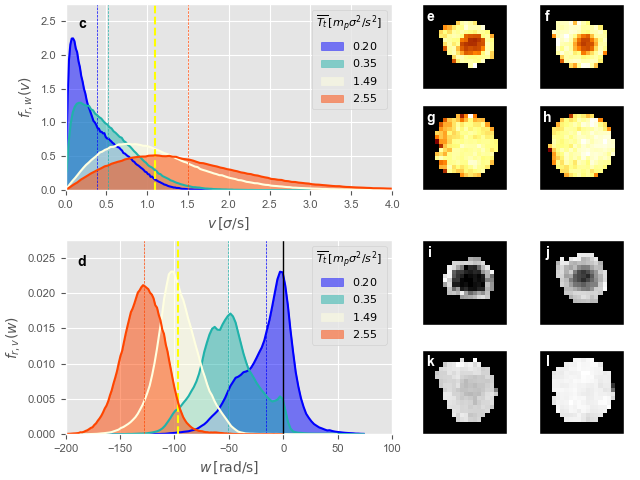

In [24]:
plt.style.use('ggplot')
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['font.style'] = 'normal'
plt.rcParams['font.size'] = 8


########################## create figure panel structure #########################
fig1 = plt.figure(constrained_layout=True)
gs1 = fig1.add_gridspec(nrows=4, ncols=5)
##################################################################################


######################### distribution func. panels & customizations #############
font_fs={'size':10, 'weight':'bold'}

f1_ax1 = fig1.add_subplot(gs1[:2, :-2])
f1_ax1.set_xlabel(r'$v\,[\sigma/\mathrm{s}]$',fontsize=10)
f1_ax1.set_ylabel(r'$f_{r,w}(v)$',fontsize=10)
f1_ax1.set_title('c', x=0.05,y = 0.825, fontdict=font_fs)

f1_ax2 = fig1.add_subplot(gs1[2:, :-2])
f1_ax2.set_xlabel(r'$w\,[\mathrm{rad/s}]$',fontsize=10)
f1_ax2.set_ylabel(r'$f_{r,v}(w)$',fontsize=10)
f1_ax2.set_title('d', x=0.05,y = 0.825, fontdict=font_fs)


### field figures panels and customizations ##################
font_fields = {'size':10, 'color':'white', 'weight':'bold'}

f1_ax3 = fig1.add_subplot(gs1[0, -2])
f1_ax3.set_xticks([])
f1_ax3.set_yticks([])
f1_ax3.set_aspect(1)
f1_ax3.set_title('e', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax3b = fig1.add_subplot(gs1[0, -1])
f1_ax3b.set_xticks([])
f1_ax3b.set_yticks([])
f1_ax3b.set_aspect(1)
f1_ax3b.set_title('f', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax4 = fig1.add_subplot(gs1[1, -2])
f1_ax4.set_xticks([])
f1_ax4.set_yticks([])
f1_ax4.set_aspect(1)
f1_ax4.set_title('g', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax4b = fig1.add_subplot(gs1[1, -1])
f1_ax4b.set_xticks([])
f1_ax4b.set_yticks([])
f1_ax4b.set_aspect(1)
f1_ax4b.set_title('h', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax5 = fig1.add_subplot(gs1[2, -2])
f1_ax5.set_xticks([])
f1_ax5.set_yticks([])
f1_ax5.set_aspect(1)
f1_ax5.set_title('i', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax5b = fig1.add_subplot(gs1[2, -1])
f1_ax5b.set_xticks([])
f1_ax5b.set_yticks([])
f1_ax5b.set_aspect(1)
f1_ax5b.set_title('j', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax6 = fig1.add_subplot(gs1[3, -2])
f1_ax6.set_xticks([])
f1_ax6.set_yticks([])
f1_ax6.set_aspect(1)
f1_ax6.set_title('k', x=0.1,y = 0.705,fontdict=font_fields)

f1_ax6b = fig1.add_subplot(gs1[3, -1])
f1_ax6b.set_xticks([])
f1_ax6b.set_yticks([])
f1_ax6b.set_aspect(1)
f1_ax6b.set_title('l', x=0.1,y = 0.705,fontdict=font_fields)


###########################################################################################




#################################  f(v) ###################################################
nbins = 120
len_unit = info.particle_diameter_px[0]
vel_unit = len_unit/250

tabla=d[10]
v = np.sqrt(tabla.vx.to_numpy()**2 + tabla.vy.to_numpy()**2)/vel_unit
v0 = np.mean(v)
fpeak = 2.75
hist, bin_edges, bin_i = stats.binned_statistic(v, v,statistic='count',bins=nbins, range = (0,2))
dx = bin_edges[1]-bin_edges[0]
dens = hist/ (dx*np.sum(hist))

f1_ax1.plot(bin_edges[:-1] + 0.5*dx, dens, color='b')
f1_ax1.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='b', alpha=0.5,  label = r'$0.20$')
f1_ax1.plot(v0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='b',lw=0.5)
f1_ax1.set_ylim(0,fpeak)
f1_ax1.set_xlim(0,4)

tabla = d[0]
v = np.sqrt(tabla.vx.to_numpy()**2 + tabla.vy.to_numpy()**2)/vel_unit
v0 = np.mean(v)
hist, bin_edges, bin_i = stats.binned_statistic(v, v,statistic='count',bins=nbins, range=(0,3))
dx = bin_edges[1]-bin_edges[0]

dens = hist/ (dx*np.sum(hist))

f1_ax1.plot(bin_edges[:-1] + 0.5*dx, dens, color='lightseagreen')
f1_ax1.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='lightseagreen', alpha=0.5, label = r'$0.35$')
f1_ax1.plot(v0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='lightseagreen',lw=0.5)


tabla = d[1]
v = np.sqrt(tabla.vx.to_numpy()**2 + tabla.vy.to_numpy()**2)/vel_unit
v0 = np.mean(v)
hist, bin_edges, bin_i = stats.binned_statistic(v, v,statistic='count',bins=nbins,range=(0,4))
dx = bin_edges[1]-bin_edges[0]

dens = hist/ (dx*np.sum(hist))

f1_ax1.plot(bin_edges[:-1] + 0.5*dx, dens, color='lightyellow')
f1_ax1.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='lightyellow', alpha=0.5, label=r'$1.49$')
f1_ax1.plot(v0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='yellow',lw=1.5)

tabla = d[2]
v = np.sqrt(tabla.vx.to_numpy()**2 + tabla.vy.to_numpy()**2)/vel_unit
v0 = np.mean(v)
hist, bin_edges, bin_i = stats.binned_statistic(v, v,statistic='count',bins=nbins, range=(0,5))
dx = bin_edges[1]-bin_edges[0]

dens = hist/ (dx*np.sum(hist))

f1_ax1.plot(bin_edges[:-1] + 0.5*dx, dens, color='orangered')
f1_ax1.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='orangered', alpha=0.5, label= r'$2.55$')
f1_ax1.plot(v0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='orangered',lw=0.5)


matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['font.size'] = 8
f1_ax1.legend(loc='upper right',title=r'$\overline{T_t}\,[m_p\sigma^2/s^2]$');

#######################################################################################################



#################################  f(w) ###################################################
nbins = 125
spin_unit = nblades/(2*np.pi*900)

tabla = dw[1]
s = tabla.w/spin_unit
w0 = np.mean(s)
fpeak =0.0275
hist, bin_edges, bin_i = stats.binned_statistic(s, s,statistic='count',bins=nbins, range=(-225, 75))
dx = bin_edges[1]-bin_edges[0]
dens = hist/ (dx*np.sum(hist))

f1_ax2.plot(bin_edges[:-1] + 0.5*dx, dens, color='b')
f1_ax2.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='b', alpha=0.5,  label = r'$0.20$')
f1_ax2.plot(w0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='b',lw=0.5)
f1_ax2.set_ylim(0,fpeak)
f1_ax2.set_xlim(-200,100)
#f1_ax2.set_xticks([-0.004,-0.003,-0.002,-0.001,0,0.001,0.002,0.003])
#f1_ax2.set_xticklabels([r'$-0.004$','',r'$-0.002$','',r'$0$','',r'$0.002$',''])

tabla = dw[3]
s = tabla.w/spin_unit
w0 = np.mean(s)
hist, bin_edges, bin_i = stats.binned_statistic(s, s,statistic='count',bins=nbins, range=(-225, 75))
dx = bin_edges[1]-bin_edges[0]
dens = hist/ (dx*np.sum(hist))

f1_ax2.plot(bin_edges[:-1] + 0.5*dx, dens, color='lightseagreen')
f1_ax2.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='lightseagreen', alpha=0.5, label = r'$0.35$')
f1_ax2.plot(w0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='lightseagreen',lw=0.5)

tabla = dw[0]
s = tabla.w/spin_unit
w0 = np.mean(s)
hist, bin_edges, bin_i = stats.binned_statistic(s, s,statistic='count',bins=nbins, range=(-225, 50))
dx = bin_edges[1]-bin_edges[0]
dens = hist/ (dx*np.sum(hist))

f1_ax2.plot(bin_edges[:-1] + 0.5*dx, dens, color='lightyellow')
f1_ax2.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='lightyellow', alpha=0.5, label=r'$1.49$')
f1_ax2.plot(w0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='yellow',lw=1.5)

tabla = dw[6]
s = tabla.w/spin_unit
w0 = np.mean(s)
hist, bin_edges, bin_i = stats.binned_statistic(s, s,statistic='count',bins=nbins, range=(-200, 0))
dx = bin_edges[1]-bin_edges[0]
dens = hist/ (dx*np.sum(hist))

f1_ax2.plot(bin_edges[:-1] + 0.5*dx, dens, color='orangered')
f1_ax2.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='orangered', alpha=0.5, label= r'$2.55$')
f1_ax2.plot(w0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='orangered',lw=0.5)

matplotlib.rcParams['font.weight'] = 'normal'
matplotlib.rcParams['font.style'] = 'normal'
matplotlib.rcParams['font.size'] = 8
f1_ax2.legend(title=r'$\overline{T_t}\,[m_p\sigma^2/s^2]$');

f1_ax2.plot(np.zeros(100),np.linspace(0,fpeak*1.2,100),'-',color='k',lw=1.)
#######################################################################################################





##################################### thermal velocity fields (4 temperature cases)  ##############################

L = info.ROI_radius[0]-info.particle_diameter_px[0]*0.5
R = info.ROI_radius[0]*1.1
ranges = ((-1.1*R,1.1*R),(-1.1*R,1.1*R))

nbins = 20

tabla = d[10]
vx = tabla.vx.to_numpy()
vy = tabla.vy.to_numpy()
hist2Dx, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vx,\
                                statistic='std', bins=nbins, range= ranges )
hist2Dy, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vy,\
                                statistic='std', bins=nbins, range= ranges )
hist2D = hist2Dx + hist2Dy
hist2D = np.where(np.isnan(hist2D )==True,0,  hist2D)

dx = xs[1]-xs[0]
dy = ys[1] - ys[0]
densw2D = hist2D/(np.sum(hist2D)*dx*dy)
X, Y = np.meshgrid(xs[:-1] ,ys[:-1])


draw_circle = plt.Circle((0, 0), R*0.9, fill=False, color='y', linewidth=2)

f1_ax3.add_artist(draw_circle)
#norm= matplotlib.colors.Normalize(0,np.max(densw2D))
fig=f1_ax3.pcolormesh(X, Y, densw2D, cmap='afmhot')
#fig1.colorbar(fig,ax=f1_ax3)

tabla = d[0]
vx = tabla.vx.to_numpy()
vy = tabla.vy.to_numpy()
hist2Dx, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vx,\
                                statistic='std', bins=nbins, range= ranges )
hist2Dy, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vy,\
                                statistic='std', bins=nbins, range= ranges )
hist2D = hist2Dx + hist2Dy
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.9, fill=False, color='y', linewidth=2)

f1_ax3b.add_artist(draw_circle)
fig=f1_ax3b.pcolormesh(X, Y, densw2D, cmap='afmhot')
#fig1.colorbar(fig,ax=f1_ax3b)

tabla = d[1]
vx = tabla.vx.to_numpy()
vy = tabla.vy.to_numpy()
hist2Dx, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vx,\
                                statistic='std', bins=nbins, range= ranges )
hist2Dy, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vy,\
                                statistic='std', bins=nbins, range= ranges )
hist2D = hist2Dx + hist2Dy
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.9, fill=False, color='y', linewidth=2)

f1_ax4.add_artist(draw_circle)
fig=f1_ax4.pcolormesh(X, Y, densw2D, cmap='afmhot')
#fig1.colorbar(fig,ax=f1_ax4)


tabla = d[2]
vx = tabla.vx.to_numpy()
vy = tabla.vy.to_numpy()
hist2Dx, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vx,\
                                statistic='std', bins=nbins, range= ranges )
hist2Dy, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vy,\
                                statistic='std', bins=nbins, range= ranges )
hist2D = (hist2Dx + hist2Dy)
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.9, fill=False, color='y', linewidth=2)

f1_ax4b.add_artist(draw_circle)
fig=f1_ax4b.pcolormesh(X, Y, densw2D, cmap='afmhot')
#fig1.colorbar(fig,ax=f1_ax4b)
#######################################################################################################




##################################### spin fields (4 temperature cases)  ##############################

L = info.ROI_radius[0]-info.particle_diameter_px[0]*0.5
R = info.ROI_radius[0]*1.1
ranges = ((-1.1*R,1.1*R),(-1.1*R,1.1*R))

nbins = 20

tabla = dw[1]
hist2D, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, tabla.w,\
                                statistic='mean', bins=nbins, range= ranges )
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(-np.sum(hist2D)*dx*dy)

dx = xs[1]-xs[0]
dy = ys[1] - ys[0]
X, Y = np.meshgrid(xs[:-1] ,ys[:-1])


draw_circle = plt.Circle((0, 0), R*0.9, fill=False, color='y', linewidth=2)

f1_ax5.add_artist(draw_circle)
#norm= matplotlib.colors.Normalize(np.min(densw2D),np.max(densw2D))
f1_ax5.pcolormesh(X, Y, densw2D, cmap='binary')


tabla = dw[3]
hist2D, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, tabla.w,\
                                statistic='mean', bins=nbins, range= ranges)
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(-np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.9, fill=False, color='y', linewidth=2)

f1_ax5b.add_artist(draw_circle)
f1_ax5b.pcolormesh(X, Y, densw2D, cmap='binary')


tabla = dw[0]
hist2D, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, tabla.w,\
                                statistic='mean', bins=nbins, range= ranges )
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(-np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.9, fill=False, color='y', linewidth=2)

f1_ax6.add_artist(draw_circle)
f1_ax6.pcolormesh(X, Y, densw2D, cmap='binary')


tabla = dw[6]
hist2D, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, tabla.w,\
                                statistic='mean', bins=nbins, range= ranges )
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(-np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.9, fill=False, color='y', linewidth=2)

f1_ax6b.add_artist(draw_circle)
f1_ax6b.pcolormesh(X, Y, densw2D, cmap='binary')
#######################################################################################################


#fig1.savefig('fig1A_AB.pdf',bbox_inches='tight')

In [41]:
info.T

,0
experiment_id,d0baa24f923acbcef2669ee168622e45
original_file,D:/serieAspas/renivelado/movies\serieAspas_N25...
date,2038-01-19 08:06:03
shape,"[1280, 800]"
fps,900
exposure,1109
n_frames,24981
recording_time,27.756667
camera_distance,0.95
pixel_ratio,1075.862069


In [29]:
dw[0].drop(['theta'], axis=1)

,frame,track,x,y,r,vx,vy,w
0,1,0,232.732868,-266.242427,353.681966,-0.087853,0.076997,-0.287258
1,2,0,232.738292,-266.223329,353.463851,-0.169448,0.098318,-0.309616
2,3,0,232.705253,-266.197933,353.617795,-0.219793,0.130686,-0.177818
3,4,0,232.645015,-266.165430,353.641767,-0.262142,0.193167,-0.261198
4,5,0,232.568845,-266.125011,353.367820,-0.208421,0.181447,-0.219353
...,...,...,...,...,...,...,...,...
619441,24971,24,-63.595637,-82.130354,103.929093,-0.218029,-0.340577,-0.190816
619442,24972,24,-63.661447,-82.260916,104.061278,-0.224876,-0.304840,-0.296880
619443,24973,24,-63.755281,-82.386556,104.040758,-0.192937,-0.278210,-0.240190
619444,24974,24,-63.813666,-82.470930,104.340390,-0.195288,-0.293191,-0.182676


In [26]:
pwd

'/data/fvega/Codigos/blades'

In [26]:
fig1.savefig('fig1A_AB.pdf',bbox_inches='tight')

## <span style="color:blue"> N=55,  *version AB* </span>

In [45]:
plt.style.use('ggplot')
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['font.style'] = 'normal'
plt.rcParams['font.size'] = 8


########################## create figure panel structure #########################
fig1 = plt.figure(constrained_layout=True)
gs1 = fig1.add_gridspec(nrows=4, ncols=5)
##################################################################################


######################### distribution func. panels & customizations #############
font_fs={'size':10, 'weight':'bold'}

f1_ax1 = fig1.add_subplot(gs1[:2, :-2])
f1_ax1.set_xlabel(r'$v\,[\sigma/\mathrm{s}]$',fontsize=10)
f1_ax1.set_ylabel(r'$f_{r,w}(v)$',fontsize=10)
f1_ax1.set_title('a', x=0.05,y = 0.85, fontdict=font_fs)

f1_ax2 = fig1.add_subplot(gs1[2:, :-2])
f1_ax2.set_xlabel(r'$w\,[\mathrm{rad/s}]$',fontsize=10)
f1_ax2.set_ylabel(r'$f_{r,v}(w)$',fontsize=10)
f1_ax2.set_title('b', x=0.05,y = 0.85, fontdict=font_fs)


### field figures panels and customizations ##################
font_fields = {'size':10, 'color':'white', 'weight':'bold'}

f1_ax3 = fig1.add_subplot(gs1[0, -2])
f1_ax3.set_xticks([])
f1_ax3.set_yticks([])
f1_ax3.set_aspect(1)
f1_ax3.set_title('c', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax3b = fig1.add_subplot(gs1[0, -1])
f1_ax3b.set_xticks([])
f1_ax3b.set_yticks([])
f1_ax3b.set_aspect(1)
f1_ax3b.set_title('d', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax4 = fig1.add_subplot(gs1[1, -2])
f1_ax4.set_xticks([])
f1_ax4.set_yticks([])
f1_ax4.set_aspect(1)
f1_ax4.set_title('e', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax4b = fig1.add_subplot(gs1[1, -1])
f1_ax4b.set_xticks([])
f1_ax4b.set_yticks([])
f1_ax4b.set_aspect(1)
f1_ax4b.set_title('f', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax5 = fig1.add_subplot(gs1[2, -2])
f1_ax5.set_xticks([])
f1_ax5.set_yticks([])
f1_ax5.set_aspect(1)
f1_ax5.set_title('g', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax5b = fig1.add_subplot(gs1[2, -1])
f1_ax5b.set_xticks([])
f1_ax5b.set_yticks([])
f1_ax5b.set_aspect(1)
f1_ax5b.set_title('h', x=0.1,y = 0.705, fontdict=font_fields)

f1_ax6 = fig1.add_subplot(gs1[3, -2])
f1_ax6.set_xticks([])
f1_ax6.set_yticks([])
f1_ax6.set_aspect(1)
f1_ax6.set_title('i', x=0.1,y = 0.705,fontdict=font_fields)

f1_ax6b = fig1.add_subplot(gs1[3, -1])
f1_ax6b.set_xticks([])
f1_ax6b.set_yticks([])
f1_ax6b.set_aspect(1)
f1_ax6b.set_title('j', x=0.1,y = 0.705,fontdict=font_fields)


###########################################################################################




#################################  f(v) ###################################################
nbins = 120
len_unit = info.particle_diameter_px[0]
vel_unit = len_unit/250

tabla=d[0]
v = np.sqrt(tabla.vx.to_numpy()**2 + tabla.vy.to_numpy()**2)/vel_unit
v0 = np.mean(v)
fpeak = 1.
hist, bin_edges, bin_i = stats.binned_statistic(v, v,statistic='count',bins=nbins)
dx = bin_edges[1]-bin_edges[0]
dens = hist/ (dx*np.sum(hist))

f1_ax1.plot(bin_edges[:-1] + 0.5*dx, dens, color='b')
f1_ax1.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='b', alpha=0.5,  label = r'$0.75$')
f1_ax1.plot(v0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='b',lw=0.5)
f1_ax1.set_ylim(0,fpeak)
f1_ax1.set_xlim(0,6)

tabla = d[7]
v = np.sqrt(tabla.vx.to_numpy()**2 + tabla.vy.to_numpy()**2)/vel_unit
v0 = np.mean(v)
hist, bin_edges, bin_i = stats.binned_statistic(v, v,statistic='count',bins=nbins)
dx = bin_edges[1]-bin_edges[0]

dens = hist/ (dx*np.sum(hist))

f1_ax1.plot(bin_edges[:-1] + 0.5*dx, dens, color='lightseagreen')
f1_ax1.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='lightseagreen', alpha=0.5, label = r'$0.91$')
f1_ax1.plot(v0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='lightseagreen',lw=0.5)


tabla = d[6]
v = np.sqrt(tabla.vx.to_numpy()**2 + tabla.vy.to_numpy()**2)/vel_unit
v0 = np.mean(v)
hist, bin_edges, bin_i = stats.binned_statistic(v, v,statistic='count',bins=nbins)
dx = bin_edges[1]-bin_edges[0]

dens = hist/ (dx*np.sum(hist))

f1_ax1.plot(bin_edges[:-1] + 0.5*dx, dens, color='lightyellow')
f1_ax1.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='lightyellow', alpha=0.5, label=r'$1.49$')
f1_ax1.plot(v0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='yellow',lw=1.5)

tabla = d[15]
v = np.sqrt(tabla.vx.to_numpy()**2 + tabla.vy.to_numpy()**2)/vel_unit
v0 = np.mean(v)
hist, bin_edges, bin_i = stats.binned_statistic(v, v,statistic='count',bins=nbins)
dx = bin_edges[1]-bin_edges[0]

dens = hist/ (dx*np.sum(hist))

f1_ax1.plot(bin_edges[:-1] + 0.5*dx, dens, color='orangered')
f1_ax1.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='orangered', alpha=0.5, label= r'$2.53$')
f1_ax1.plot(v0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='orangered',lw=0.5)


matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['font.size'] = 8
f1_ax1.legend(loc='upper right',title=r'$\overline{T_t}\,[m_p\sigma^2/s^2]$');

#######################################################################################################



#################################  f(w) ###################################################
nbins = 175
spin_unit = nblades/(2*np.pi*info.fps[0])

tabla = dw[3]
s = tabla.w/spin_unit
w0 = np.mean(s)
fpeak = 0.2
hist, bin_edges, bin_i = stats.binned_statistic(s, s,statistic='count',bins=nbins, range=(-16,8))
dx = bin_edges[1]-bin_edges[0]
dens = hist/ (dx*np.sum(hist))

f1_ax2.plot(bin_edges[:-1] + 0.5*dx, dens, color='b')
f1_ax2.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='b', alpha=0.5,  label = r'$0.75$')
f1_ax2.plot(w0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='b',lw=0.5)
f1_ax2.set_ylim(0,fpeak)
f1_ax2.set_xlim(-16,8)
f1_ax2.set_yticks([0, 0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2])
f1_ax2.set_yticklabels([r'$0$','',r'$0.05$','',r'$0.10$','',r'$0.15$','', r'$0.20$'])
f1_ax2.set_xticks([-15, -12.5,-10,-7.5,-5,-2.5,0,2.5,5])
f1_ax2.set_xticklabels([r'$-15$','',r'$-10$','',r'$-5$','',r'$0$','', r'$5$'])


tabla = dw[0]
s = tabla.w/spin_unit
w0 = np.mean(s)
hist, bin_edges, bin_i = stats.binned_statistic(s, s,statistic='count',bins=nbins, range=(-16,6))
dx = bin_edges[1]-bin_edges[0]
dens = hist/ (dx*np.sum(hist))

f1_ax2.plot(bin_edges[:-1] + 0.5*dx, dens, color='lightseagreen')
f1_ax2.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='lightseagreen', alpha=0.5, label = r'$0.91$')
f1_ax2.plot(w0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='lightseagreen',lw=0.5)

tabla = dw[2]
s = tabla.w/spin_unit
w0 = np.mean(s)
hist, bin_edges, bin_i = stats.binned_statistic(s, s,statistic='count',bins=nbins, range=(-16,4))
dx = bin_edges[1]-bin_edges[0]
dens = hist/ (dx*np.sum(hist))

f1_ax2.plot(bin_edges[:-1] + 0.5*dx, dens, color='lightyellow')
f1_ax2.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='lightyellow', alpha=0.5, label=r'$1.49$')
f1_ax2.plot(w0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='yellow',lw=1.5)

tabla = dw[1]
s = tabla.w/spin_unit
w0 = np.mean(s)
hist, bin_edges, bin_i = stats.binned_statistic(s, s,statistic='count',bins=nbins, range=(-16,2))
dx = bin_edges[1]-bin_edges[0]
dens = hist/ (dx*np.sum(hist))

f1_ax2.plot(bin_edges[:-1] + 0.5*dx, dens, color='orangered')
f1_ax2.fill_between(bin_edges[:-1] + 0.5*dx, dens, 0, color='orangered', alpha=0.5, label= r'$2.53$')
f1_ax2.plot(w0*np.ones(100),np.linspace(0,fpeak*1.2,100),'--',color='orangered',lw=0.5)

matplotlib.rcParams['font.weight'] = 'normal'
matplotlib.rcParams['font.style'] = 'normal'
matplotlib.rcParams['font.size'] = 8
f1_ax2.legend(title=r'$\overline{T_t}\,[m_p\sigma^2/s^2]$');

f1_ax2.plot(np.zeros(100),np.linspace(0,fpeak*1.2,100),'-',color='k',lw=1.)
#######################################################################################################




##################################### thermal velocity fields (4 temperature cases)  ##############################

L = info.ROI_radius[0]-info.particle_diameter_px[0]*0.5
R = info.ROI_radius[0]*1.1
ranges = ((-1.1*R,1.1*R),(-1.1*R,1.1*R))

nbins = 20

tabla = d[0]
vx = tabla.vx.to_numpy()
vy = tabla.vy.to_numpy()
hist2Dx, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vx,\
                                statistic='std', bins=nbins, range= ranges )
hist2Dy, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vy,\
                                statistic='std', bins=nbins, range= ranges )
hist2D = hist2Dx + hist2Dy
hist2D = np.where(np.isnan(hist2D )==True,0,  hist2D)

dx = xs[1]-xs[0]
dy = ys[1] - ys[0]
densw2D = hist2D/(np.sum(hist2D)*dx*dy)
X, Y = np.meshgrid(xs[:-1] ,ys[:-1])


draw_circle = plt.Circle((0, 0), R*0.925, fill=False, color='y', linewidth=2)

f1_ax3.add_artist(draw_circle)
#norm= matplotlib.colors.Normalize(0,np.max(densw2D))
fig=f1_ax3.pcolormesh(X, Y, densw2D, cmap='afmhot')
#fig1.colorbar(fig,ax=f1_ax3)

tabla = d[7]
vx = tabla.vx.to_numpy()
vy = tabla.vy.to_numpy()
hist2Dx, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vx,\
                                statistic='std', bins=nbins, range= ranges )
hist2Dy, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vy,\
                                statistic='std', bins=nbins, range= ranges )
hist2D = hist2Dx + hist2Dy
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.925, fill=False, color='y', linewidth=2)

f1_ax3b.add_artist(draw_circle)
fig=f1_ax3b.pcolormesh(X, Y, densw2D, cmap='afmhot')
#fig1.colorbar(fig,ax=f1_ax3b)

tabla = d[6]
vx = tabla.vx.to_numpy()
vy = tabla.vy.to_numpy()
hist2Dx, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vx,\
                                statistic='std', bins=nbins, range= ranges )
hist2Dy, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vy,\
                                statistic='std', bins=nbins, range= ranges )
hist2D = hist2Dx + hist2Dy
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.925, fill=False, color='y', linewidth=2)

f1_ax4.add_artist(draw_circle)
fig=f1_ax4.pcolormesh(X, Y, densw2D, cmap='afmhot')
#fig1.colorbar(fig,ax=f1_ax4)


tabla = d[15]
vx = tabla.vx.to_numpy()
vy = tabla.vy.to_numpy()
hist2Dx, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vx,\
                                statistic='std', bins=nbins, range= ranges )
hist2Dy, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, vy,\
                                statistic='std', bins=nbins, range= ranges )
hist2D = (hist2Dx + hist2Dy)
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.925, fill=False, color='y', linewidth=2)

f1_ax4b.add_artist(draw_circle)
fig=f1_ax4b.pcolormesh(X, Y, densw2D, cmap='afmhot')
#fig1.colorbar(fig,ax=f1_ax4b)
#######################################################################################################




##################################### spin fields (4 temperature cases)  ##############################

L = info.ROI_radius[0]-info.particle_diameter_px[0]*0.5
R = info.ROI_radius[0]*1.1
ranges = ((-1.1*R,1.1*R),(-1.1*R,1.1*R))

nbins = 20

tabla = dw[3]
hist2D, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, tabla.w,\
                                statistic='mean', bins=nbins, range= ranges )
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(-np.sum(hist2D)*dx*dy)

dx = xs[1]-xs[0]
dy = ys[1] - ys[0]
X, Y = np.meshgrid(xs[:-1] ,ys[:-1])


draw_circle = plt.Circle((0, 0), R*0.925, fill=False, color='y', linewidth=2)

f1_ax5.add_artist(draw_circle)
#norm= matplotlib.colors.Normalize(np.min(densw2D),np.max(densw2D))
f1_ax5.pcolormesh(X, Y, densw2D, cmap='binary')


tabla = dw[0]
hist2D, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, tabla.w,\
                                statistic='mean', bins=nbins, range= ranges)
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(-np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.925, fill=False, color='y', linewidth=2)

f1_ax5b.add_artist(draw_circle)
f1_ax5b.pcolormesh(X, Y, densw2D, cmap='binary')


tabla = dw[2]
hist2D, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, tabla.w,\
                                statistic='mean', bins=nbins, range= ranges )
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(-np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.925, fill=False, color='y', linewidth=2)

f1_ax6.add_artist(draw_circle)
f1_ax6.pcolormesh(X, Y, densw2D, cmap='binary')


tabla = dw[1]
hist2D, xs, ys, binnumber = stats.binned_statistic_2d(tabla.x, tabla.y, tabla.w,\
                                statistic='mean', bins=nbins, range= ranges )
hist2D = np.where(np.isnan(hist2D )==True, 0,  hist2D)
densw2D = hist2D/(-np.sum(hist2D)*dx*dy)


draw_circle = plt.Circle((0, 0), R*0.925, fill=False, color='y', linewidth=2)

f1_ax6b.add_artist(draw_circle)
f1_ax6b.pcolormesh(X, Y, densw2D, cmap='binary')
#######################################################################################################


fig1.savefig('fig1B_AB.pdf',bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [41]:
plt.close('all')

In [156]:
fig8 = plt.figure()

gs1 = fig8.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.95, wspace=0.5,hspace=0.5)
f8_ax1 = fig8.add_subplot(gs1[:-1, :])
f8_ax2 = fig8.add_subplot(gs1[-1, :-1])
f8_ax3 = fig8.add_subplot(gs1[-1, -1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Manuscript figure 4. Statistical correlations

In [23]:
plt.style.use('default')

tabla = pd.read_csv('/data/Datos/blades/fields/momentsRr_N25_4.dat', sep='\s+')
T_crit = pd.read_csv('/data/Datos/blades/fields/T_crit.dat',sep='\s+').iloc[0]

r = [tabla.r.values[i] for i in range(4)]

matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['font.style'] = 'normal'
plt.rcParams['font.size'] = 8

fig4s, ax1 = plt.subplots(figsize=(5,5))

font_title={'size':12, 'weight':'bold'}
#ax1 = fig4s.add_subplot()
ax1.set_xlabel(r'$T_t$',fontsize=14)
ax1.set_ylabel(r'$a_{20}$', color='b',labelpad=-1,fontsize=14)
ax2 = ax1.twinx() # second Y axis sharing the same X axis
ax2.set_yscale('log')
ax2.set_ylabel(r'$a_{02}$',color='r',labelpad=-1,fontsize=14)


# markers list
m = ['o', '^','s','D']

Tu =(300/74)**2 # inverse of temperature unit
Tur = (2*np.pi*900/14)**2/8 # inverse of rotational temperature unit
for i in range(4):
    ax1.plot(tabla[tabla.r==r[i]].Tt*Tu, tabla[tabla.r==r[i]].a20, marker=m[i], c='b', mfc='none', ms=8, ls='none')
    ax2.plot(tabla[tabla.r==r[i]].Tt*Tu, tabla[tabla.r==r[i]].a02, marker=m[i], c='r', ms=8, ls='none')

#fig4s.savefig('fig4s.pdf',bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [44]:
plt.style.use('default')

tabla = pd.read_csv('/data/Datos/blades/fields/momentsRr_N55_4.dat', sep='\s+')
#tabla = pd.read_csv('/data/Codigos/blades/momentsRr_N25_4.dat', sep='\s+')
#T_crit = pd.read_csv('/data/Datos/blades/fields/T_crit.dat',sep='\s+').iloc[0]

r = [tabla.r.values[i] for i in range(4)]

matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['font.style'] = 'normal'
plt.rcParams['font.size'] = 10

fig4s, ax1 = plt.subplots(figsize=(5,5))

font_title={'size':12, 'weight':'bold'}
#ax1 = fig4s.add_subplot()
ax1.set_xlabel(r'$\overline{T_t}$',fontsize=14)
ax1.set_ylabel(r'$a_{00a}$', color='b',labelpad=-1,fontsize=14)


# markers list
m = ['o', '^','s','D']

Tu =(300/74)**2 # inverse of temperature unit
Tur = (2*np.pi*900/14)**2/8 # inverse of rotational temperature unit
for i in range(3):
    ax1.plot(tabla[tabla.r==r[i]].Tt*Tu, tabla[tabla.r==r[i]].a00a, marker=m[i], c='b', mfc='none', ms=8, ls='none')

fig4s.savefig('fig4a00a.pdf',bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
plt.style.use('default')

tabla = pd.read_csv('/data/Datos/blades/fields/momentsRr_N25_4.dat', sep='\s+')
T_crit = pd.read_csv('/data/Datos/blades/fields/T_crit.dat',sep='\s+').iloc[0]

r = [tabla.r.values[i] for i in range(4)]

matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['font.style'] = 'normal'
plt.rcParams['font.size'] = 8

fig4 = plt.figure(figsize=(2*4,4) )
gs4 = fig4.add_gridspec(nrows=1, ncols=2,left =0.1, right=0.95, wspace=0.55,hspace=0.250)
font_title={'size':10, 'weight':'bold'}

plt.style.use('seaborn-dark')
f4_ax1 = fig4.add_subplot(gs4[0, 0])
f4_ax1 .tick_params(direction='inout', length=6, colors='k',
               grid_color='k', grid_alpha=0.5)
f4_ax1.set_xlabel(r'$\overline{T_t}\, [m_p(\sigma/\mathrm{s})^2]$', fontsize=10)
f4_ax1.set_ylabel(r'$a_{11}^{(0)}$ (blue)', fontsize=10, color='b')
f4_ax1.set_title('a', loc='left', fontdict=font_title)

plt.style.use('default')

f4_ax12 = f4_ax1.twinx() # second Y axis sharing the same X axis 
f4_ax12.set_ylabel(r'$T_t/T^*_r$ (red)' ,fontsize=10, color='r', labelpad=-1)
f4_ax12.set_yscale('log')


plt.rcParams['font.size'] = 6
axin1 = f4_ax1.inset_axes([0.625, 0.4, 0.25, 0.25])
axin1.set_xlabel(r'$\overline{T_t}$',fontsize=8)
axin1.set_ylabel(r'$a_{00}^{(1)}$', color='k',labelpad=-1,fontsize=8)
#axin2 = axin1.twinx() # second Y axis sharing the same X axis
#axin2.set_yscale('log')
#axin2.set_ylabel(r'$a_{02}$',color='r',labelpad=-1,fontsize=8)


plt.rcParams['font.size'] = 8

f4_ax2 = fig4.add_subplot(gs4[0, 1])
#f4_ax22 = f4_ax2.twinx() # second Y axis sharing the same X axis
f4_ax2.set_ylim(-4.5,0.5 )
f4_ax2.set_xlim(0,4.5)
f4_ax2.set_xlabel(r'$\overline{T_t}\, [m_p(\sigma/\mathrm{s})^2]$', fontsize=10)
f4_ax2.set_ylabel(r'$\mathrm{d}T_t/\mathrm{d}r\: [m_p\sigma/s^2]$',fontsize=10)
f4_ax2.set_title('b', loc='left', fontdict=font_title)

plt.rcParams['font.size'] = 6
axin22 = f4_ax2.inset_axes([0.175, 0.12, 0.45, 0.275])
axin22.set_xlabel(r'$r\,[\sigma]$', fontsize=8, labelpad=-1)
axin22.set_ylabel(r'$\mathrm{d}T_t/\mathrm{d}r$', labelpad=-1, fontsize=8)
axin22.set_xscale('log')

plt.rcParams['font.size'] = 8
# markers list
m = ['o', '^','s','D']
m2 = ['o', 'o','s','x']
Tu =(300/74)**2 # inverse of temperature unit
Tur = (2*np.pi*900/14)**2/8 # inverse of rotational temperature unit

for i in range(4):
    f4_ax1.plot(tabla[tabla.r==r[i]].Tt*Tu, tabla[tabla.r==r[i]].a11, marker=m[i], c='b', mfc='none', ms=5, ls='none')
    f4_ax1.plot(T_crit.c*np.ones(10), np.linspace(-0.2,0.5,10), '--', color='k')
    f4_ax12.plot(tabla[tabla.r==r[i]].Tt*Tu, Tu*tabla[tabla.r==r[i]].Tt/( Tur*tabla[tabla.r==r[i]].Tr), marker=m[i], c='r', ms=5, ls='none')
    if i!=1:
        axin1.plot(tabla[tabla.r==r[i]].Tt*Tu, tabla[tabla.r==r[i]].a00, marker=m2[i], c='k', mfc='none', ms=3, ls='none')
        axin1.axhline(0, color='k',lw=0.5)

mins = [-0.2, -0.1, -0.06, 0.04]
maxs = [ 0.01, 0.015, 0.142, 0.16]
Tss = [0,2,4,6.5]
axin1.fill_between(Tss ,mins, maxs, alpha=0.4,color='grey' )
axin1.set_xlim(0,6.5)
axin1.set_ylim(-0.1,0.15)

f4_ax1.fill_betweenx(np.linspace(-0.12,0.5,20), T_crit.izq,T_crit.der,alpha=0.8, color='lemonchiffon' )
f4_ax1.set_ylim(-0.06,0.2 )
f4_ax1.set_xlim(0,0.4*Tu)
f4_ax1.axhline(0, color='k',lw=0.5)

maxs = stats.binned_statistic(tabla.Tt*Tu, tabla.Tt*Tu/(tabla.Tr*Tur), statistic='max', bins=6, range=(0,0.4*Tu))
mins = stats.binned_statistic(tabla.Tt*Tu, tabla.Tt*Tu/(tabla.Tr*Tur), statistic='min', bins=6, range=(0,0.4*Tu))
dT = np.diff(mins[1])

maxss = np.insert(maxs[0],0,maxs[0][0]*0.8)
minss = np.insert(mins[0],0,mins[0][0]*0.7)
maxss = np.append(maxss,maxss[-1])
minss = np.append(minss,minss[-1])
dT = np.insert(dT,0,dT[0])
dT = np.append(dT,dT[-1])
minss1 = np.append(mins[1], mins[1][-1]+dT[-1])
#minss = np.append(mins[0], tabla.Tt.values[-1]/tabla.Tr.values[-1])
#maxss = np.append(maxs[0], tabla.Tt.values[-1]/tabla.Tr.values[-1])
#f4_ax12.fill_between(mins[1][:-1]+dT*0.5 , mins[0]*0.8, maxs[0]*1.05, alpha=0.2,color='lightsalmon' )
f4_ax12.fill_between(minss1-dT*0.5 , minss*0.8, maxss*1.05, alpha=0.4,color='lightsalmon' )
  
maxs = stats.binned_statistic(tabla.Tt*Tu, tabla.a11, statistic='max', bins=4, range=(0,0.4*Tu))
mins = stats.binned_statistic(tabla.Tt*Tu, tabla.a11, statistic='min', bins=4, range=(0,0.4*Tu))
minss = np.append(mins[0], -tabla.a11.values[-1])
maxss = np.append(maxs[0], tabla.a11.values[-1])
f4_ax1.fill_between(mins[1], np.abs(minss*1.5)*np.sign(minss), maxss*1.4, alpha=0.4,color='royalblue' )


name = '/data/Datos/blades/fields/gradiente_T_serieN25.dat'
qr = pd.read_csv(name,sep='\s+')
qr_ext = qr[qr.r==qr.r.values[-2]]

name = '/data/Datos/blades/fields/gradiente_T_serieN45.dat'
qr2 = pd.read_csv(name,sep='\s+')
qr2_ext = qr2[qr2.r==qr2.r.values[-2]]

qr2_r_1 =  qr2[qr2.ID=='155e9e3bf635544e8ff7240c760bee7b'] 
qr2_r_2 =  qr2[qr2.ID=='f509f3b902a7ada8064a9247404d7019'] 
qr2_r_3 =  qr2[qr2.ID=='edc6f35457554fd45382f6becdf41d97']

qu = 78 * Tu # inverse of temperature gradient unit
f4_ax2.plot(qr_ext.Tt, qr_ext.dTt, marker=m[0], c='b', mfc='none', ms=6, ls='none', label=r'$\phi= 0.25$')
f4_ax2.plot(qr2_ext.Tt, qr2_ext.dTt, marker=m[1], c='r', mfc='none', ms=6, ls='none', label=r'$\phi= 0.45$')

axin22.plot(qr2_r_1.r[::3], qr2_r_1.dTt[::3], marker=m[0], c='b', mfc='none', ms=2, ls='none',label=r'$0.63$')
axin22.plot(qr2_r_2.r[::3], qr2_r_2.dTt[::3], marker=m[1], c='k', mfc='none', ms=2, ls='none',label=r'$1.16$')
axin22.plot(qr2_r_3.r[::3], qr2_r_3.dTt[::3], marker=m[2], c='r', mfc='none', ms=2, ls='none',label=r'$2.65$')
plt.rcParams['font.size'] = 7
axin22.legend(fontsize=6, title=r'$\overline{T_t}\,[m_p\sigma^2/\mathrm{s}^2]$')
plt.rcParams['font.size'] = 8
#f4_ax2.fill_betweenx(np.linspace(-1,0.7,21), 0.05,0.15, alpha=0.1, color='c' )
f4_ax2.legend()

f4_ax1.arrow( 0.97, 0.985*0.4*0.496, -0.6, 0, shape='full', head_length=0.075, head_width=0.01*0.5, color='c')
f4_ax1.arrow( 1.54, 0.985*0.4*0.495, 0.6, 0, shape='full', head_length=0.075, head_width=0.01*0.5, color='c')

f4_ax1.text(0.775*0.83, 0.94*0.4*0.495, 'spin-wise',  size=8, rotation=270, color ='c')
f4_ax1.text(0.90, 0.705*0.4*0.495, 'complex',  size=8,color ='c')
f4_ax1.text(1.55, 0.90*0.4*0.495, 'counter\nspin-wise',  size=8, rotation=90, color ='c');


#fig4.savefig('fig4.pdf',bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [54]:
plt.close('all')

In [62]:
len(dw[0])

1285857

In [154]:
plt.figure(figsize=(4*ct.golden_ratio,4))
#fig, ax1 = plt.subplots(figsize=(4*ct.golden_ratio,4))
plt.rcParams['font.size'] = 10
plt.xlabel('frame number')
plt.ylabel(r'$\theta$')
font_fs={'size':12, 'weight':'bold'}
plt.title('c',loc='left', fontdict=font_fs)
plt.yticks([0, np.pi/2, np.pi, np.pi*1.5, 2*np.pi], ['0', '', r'$\pi$','', r'$2\pi$'])
plt.plot(trackf(5,dw[0],True).theta[:int(Nframes)-10]*(2*np.pi/circ_unit),'o', markersize=1, color='b')
plt.savefig('fig_theta.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [128]:
dw[0].to_pickle('tabla_theta.pkl')

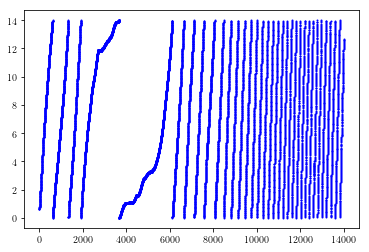

In [16]:
plt.plot(trackf(2,datos,True).theta[:14000],'o', markersize=1, color='b')

In [15]:
nbinr = 3
bins, Tt, Tr, a20, a02, a11 = momentsRr(datos, nbinr) 

/usr/lib/python3/dist-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [39]:
plt.figure()
plt.xlim(0,3)
plt.hist(np.sqrt(datos_ns.vx.values**2 + datos_ns.vy.values**2),bins=500);


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [40]:
plt.figure()

plt.hist(np.sqrt(datos_ns.x.values**2 + datos_ns.y.values**2),bins=500);


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [114]:
mur = np.mean(datos.w)
Tr = stats.moment(datos.w, moment=2)
Kr = stats.kurtosis(datos.w, fisher=False)
print(mur, Tr, Kr)

-0.20616441808764074 0.0031576141924845114 12.211440746884794


In [30]:
plt.figure(figsize=(7,7))
idp = 5
plt.plot(tracks[idp].x, tracks[idp].y,',')

/usr/lib/python3/dist-packages/matplotlib/__init__.py:882: MatplotlibDeprecationWarning: 
nbagg.transparent
  version, key, obj_type="rcparam", alternative=alt_key)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [126]:
!pwd

/home/fvega/Codigos/blades


In [76]:
plt.figure()
plt.imshow(T, interpolation='bicubic')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [57]:
info.ROI_radius[0]

408

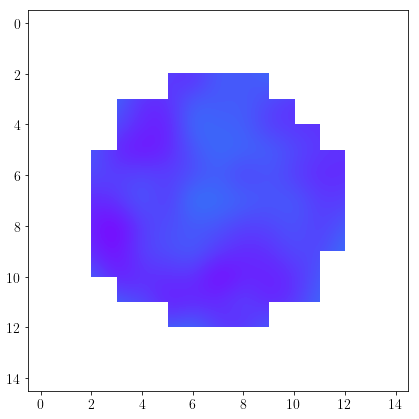

In [350]:
plt.figure(figsize=(7,7))
plt.imshow(Tr,cmap='rainbow',interpolation='bicubic')

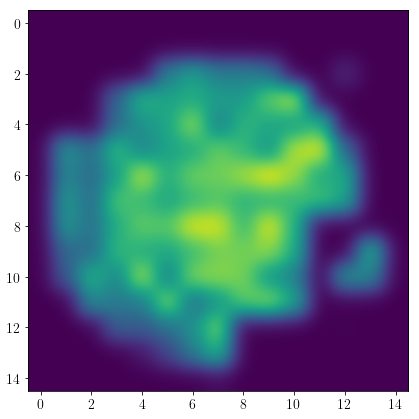

In [351]:
plt.figure(figsize=(7,7))
plt.imshow(T*n, interpolation='gaussian')

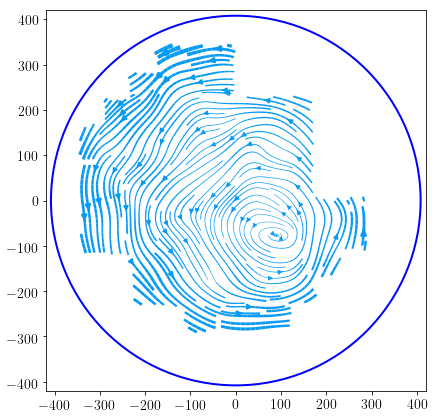

In [352]:
plt.close('all')
figure, axes = plt.subplots(figsize=(7,7))

draw_circle = plt.Circle((0, 0), 408, fill=False, color='b', linewidth=2)

axes.set_aspect(1)
axes.add_artist(draw_circle)

lw = 10* speed
plt.xlim(-420,420)
plt.ylim(-420,420)
plt.streamplot(X, Y, ux, uy, color='xkcd:azure', density=2.6, linewidth=lw)

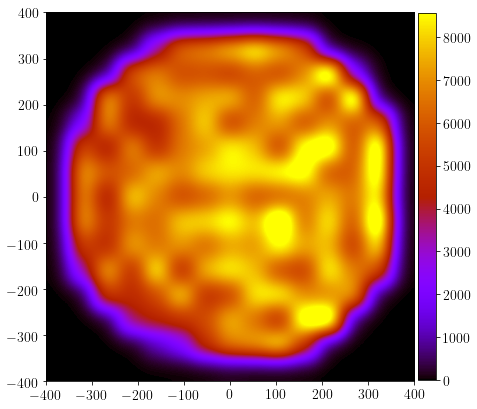

In [319]:
fig, ax1 = plt.subplots(figsize=(7, 7))

dens = plt.imshow(n, interpolation='gaussian', cmap='gnuplot',extent=(-400,400,-400,400), 
                  vmax = np.max(n)*0.75,vmin=-0.005)

fig.colorbar(dens, ax=ax1,fraction=0.047, pad=0.01)

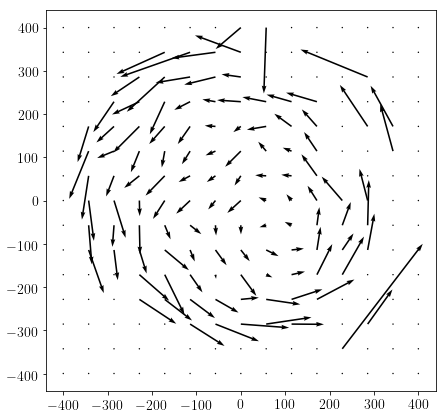

In [320]:
plt.close('all')
plt.figure(figsize=(7,7))
plt.quiver(X,Y,ux,uy)

In [166]:
archivo = open("fields_N55_T107.dat", "w")

d1, d2 = np.shape(X)

archivo.write("{0: ^10s} {1: ^10s} {2: ^10s}{3: ^10s} {4: ^10s} {5: ^10s}".format("X", "Y", "T", "n", "ux", "uy"))
archivo.write("\n")
for i in range(d1):
    for j in range(d2):
        archivo.write('{0:10.3f} {1:10.3f} {2:10.6f} {3:10.6f} {4:10.6f} {5:10.6f} \n'.format(\
                        X[i][j], Y[i][j], T[i][j], n[i][j], ux[i][j], uy[i][j] ))

archivo.close()

In [28]:
plt.close('all')
nfig=2
Nz = len(datos)
wm = np.mean(datos.w)

# pdf, bins, 
pdfw, bins, idatos =  stats.binned_statistic(datos.w, datos.w, statistic='count',bins=100)
pdfw2, bins2, idatos2 = stats.binned_statistic(np.abs(datos.w-wm), np.abs(datos.w-wm), statistic='count',bins=100)
pdfw = pdfw/Nz
pdfw2 = pdfw2/Nz

plt.figure(nfig, figsize=(8,8/ct.golden_ratio))
# log scale (Y)
plt.yscale('log') 
# axis labels
plt.xlabel(r'$\omega\,(\mathrm{rad/s})$', fontsize=14)
plt.ylabel(r'$f(\omega)$', fontsize=14)

#plt.xlim(0,0.3)
plt.plot(bins[:-1],pdfw, 'o', fillstyle='right', markersize=5, color = 'k')
plt.grid(True, axis='y', linewidth=1,which='major')
plt.grid(True, axis='y', linewidth=0.25,which='minor')

plt.figure(nfig+1, figsize=(8,8/ct.golden_ratio))
# log scale (Y)
#plt.yscale('log') 
# axis labels
plt.xlabel(r'$\omega\,(\mathrm{rad/s})$', fontsize=14)
plt.ylabel(r'$f(\omega)$', fontsize=14)

#plt.ylim(1e-3,1)
mu = np.mean(datos.w)
sigma = np.std(datos.w)
K = stats.kurtosis(datos.w)

x = np.linspace(0,1,500)
pdfM = stats.maxwell.pdf(x,loc = mu, scale= sigma)
plt.plot(x, pdfM, color='r', linewidth=2)
plt.plot(bins2[:-1],pdfw2, 'o', fillstyle='right', markersize=5, color = 'k')
plt.xlim(0,0.3)

print(mu, sigma, K)

/usr/lib/python3/dist-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

-0.20616441808764074 0.05619265247774402 9.211440746884794


In [55]:
fig, axes = plt.subplots(figsize=(7,7))
axes.set_xlim(-420,420)
axes.set_ylim(-420,420)

plt.plot(datos_ns.x.values, datos_ns.y.values,',' ,linestyle='None', markersize=10./fig.dpi ,color='grey',alpha=0.5)

draw_circle_ext = plt.Circle((0, 0), 405, fill=False, color='c', linewidth=2)
draw_circle_int = plt.Circle((0, 0), 405*2/3, fill=False, color='c', linewidth=2)
draw_circle_inn = plt.Circle((0, 0), 405/3, fill=False, color='c', linewidth=2)
#axes.set_aspect(1)
axes.add_artist(draw_circle_ext)
axes.add_artist(draw_circle_int)
axes.add_artist(draw_circle_inn)

/usr/lib/python3/dist-packages/matplotlib/__init__.py:882: MatplotlibDeprecationWarning: 
nbagg.transparent
  version, key, obj_type="rcparam", alternative=alt_key)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [54]:
plt.figure(4, figsize=(7,7/ct.golden_ratio))

x = np.linspace(0, 5, 500)
pdf = stats.maxwell.pdf(x,scale=np.std(datos.w),loc=np.mean(datos.w))
plt.plot(x,pdf, color= 'b')
pdf = stats.maxwell.pdf(x,scale=2,loc=0)
plt.plot(x,pdf, color= 'r')
pdf = stats.maxwell.pdf(x,scale=3,loc=0)
plt.plot(x,pdf, color= 'g')

AttributeError: 'DataFrame' object has no attribute 'w'

## _Plotting functions_ 

__frameit(ax):__ frames a figure by drawing the image limits and the ROI limits as well

__plt__\___track(t_id,xs,tagit,fr\_it):__ plots just one track (_t_\__id_) within _fr_\__it_ (if True) frames, with size _xs_ and prints the track no. if _tagit_ is True

__plt__\___tracks(init_id, final_id,xs,tagit,fr\_it):__ plots _init_\__id_ to _final_\__id_ tracks within _fr_\__it_ (if True) frames, with size _xs_ and prints the track no. if _tagit_ is True

In [13]:
def frameit(ax):
    ax.set_xlim(0,info['shape'][0][0])
    ax.set_ylim(0,info['shape'][0][1])
    rect = plt.Rectangle([250,50], 750, 600, alpha=1, lw=10,fill=False, edgecolor='b')
    ax.add_artist(rect)

# Plot just one track function (tagit?, frameit?)
def plt_track(t_id,xs,tagit,fr_it):
    if fr_it==True:
        fig, ax = plt.subplots(figsize=(xs,xs*info['shape'][0][1]/info['shape'][0][0]))
        px_size = 72./fig.dpi
        frameit(ax)
    else:
        fig, ax = plt.subplots()
        px_size = 72./fig.dpi
        
    plt.plot(tracks[t_id].x,tracks[t_id].y, '.', c='r', markersize=px_size,linewidth=None)
    if tagit==True:
        plt.text(np.mean(tracks[t_id].x), np.mean(tracks[t_id].y), str(t_id))
            
def plt_tracks(init_id,final_id,xs,tagit,fr_it):
    if fr_it==True:
        fig, ax = plt.subplots(figsize=(xs,xs*info['shape'][0][1]/info['shape'][0][0]))
        px_size = 72./fig.dpi
        frameit(ax)
    else:
        fig, ax = plt.subplots()
        px_size = 72./fig.dpi
    for i in range(init_id,final_id):
        plt.plot(tracks[i].x,tracks[i].y, '.', c='r', markersize=px_size,linewidth=None)
        if tagit==True:
            plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))
